# Getting and Analyzing Firing rates

In [1]:
import os
import numpy as np
import csv
import matplotlib.pyplot as plt
from matplotlib import gridspec
from scipy.io import savemat, loadmat
import datetime as dt
from combinato import Combinato, h5files, TYPE_ART, TYPE_NO, GROUP_ART, GROUP_NOCLASS, SessionManager, DataManager, SortingManager, SortingManagerGrouped
#from combinato.combinato import Combinato, h5files, TYPE_ART, TYPE_NO, GROUP_ART, GROUP_NOCLASS, SessionManager, DataManager, SortingManager, SortingManagerGrouped
import pandas as pd
#%cd /home/adrian/combinato/
#from combinato.combinato.manager.manager import *
#from combinato.combinato.manager.manager_cat import *
from combinato.manager.manager import *
from combinato.manager.manager_cat import *
from scipy.stats import ranksums
import scipy.stats as stats
import glob

%cd /media/Projects/Adrian/seizureProcessing/
#%cd ~/Documents/seizureProcessing
from seizureProcessing.utils.get_chnames import *
from seizureProcessing.utils.get_patinfo_from_path import *
from seizureProcessing.plotter.plot_raster import *
#from seizureProcessing.utils.read_spikedata import extract_from_combinato
from seizureProcessing.utils.from_micro_to_macro_names import *
from seizureProcessing.utils.readMatfile import *
from seizureProcessing.utils.readSpikeData import *

/media/Projects/Adrian/seizureProcessing


In [2]:
def get_all_spike_times_cluster_info(path, mode="collapse"):
    #Move electrode by electrode, region by region
    #Get all non-artifact spikes and add them to matrix
    #return matirx
    
    #get list of csc channels
    csc_channels = match_cssfiles_to_chnames(path)
    
    #initiate output variable
    matrix = []
    chid = []
    
    for i, ch in enumerate(csc_channels):
        print(f'extracting spikes from {ch}')
        try:
            matfile = loadSpikeData_mat(path, ch.strip('.ncs'), details=False)
            matfile.get_all_units_times_and_spikes()
        except (FileNotFoundError, IndexError):
            matrix.append([])
        
        if mode=="collapse":
            matfile.collapse_units_across_type()
            units = matfile.collapsed_units['times']
        elif mode=="SU":
            units = matfile.SU['times']
        elif mode=="MU":
            units = matfile.MU['times']

        matrix.append(units)
    return matrix, csc_channels

def from_datetime_to_timestamp(dtm, frmt='%Y-%m-%d_%H-%M-%S', scale=1e6):
    out_ts = dt.datetime.strptime(dtm, frmt)
    
    return out_ts.replace(tzinfo=dt.timezone.utc).timestamp()*scale

def add_period_to_timestamp(ts, p_sec, scale=1e6):
    '''adds a period of p_sec to a timestamp
    and returns the result
    '''
    ts_utc = dt.datetime.utcfromtimestamp(ts)
    
    out_ts_estimate = dt.timedelta(seconds=abs(p_sec))
    
    if p_sec >=0:
        out_ts = ts_utc + out_ts_estimate
    else:
        out_ts = ts_utc - out_ts_estimate
    return out_ts.replace(tzinfo=dt.timezone.utc).timestamp()*scale

def get_start_stop_timestamps(so, start_sec=None, end_sec=None, scale=1e6):
    '''
    '''
    assert end_sec > start_sec
    
    period = end_sec - start_sec
    
    onset = from_datetime_to_timestamp(so)
    
    start_ts = add_period_to_timestamp(onset/scale, start_sec)
    
    end_ts = add_period_to_timestamp(onset/scale, end_sec)
    
    return start_ts, end_ts, period

def cut_spike_data(matrix, so, start_sec, end_sec, scale=1e3):
    '''cuts spike timestamps data from a session 
    between start and end timestamps, as seconds relative
    to seizure onset (so)
    '''
    
    start_ts, end_ts, period = get_start_stop_timestamps(so, start_sec, end_sec)
    
    print(f"cutting {period} seconds starting at {dt.datetime.utcfromtimestamp(start_ts/1e6)}")
    #print(start_ts, end_ts)
    
    out = []
    for i, row in enumerate(matrix):
        #print(min(row), max(row), start_ts/1e3, end_ts/1e3)
        #print(dt.datetime.utcfromtimestamp(min(row)/1e3), dt.datetime.utcfromtimestamp(max(row)/1e3))
        cut_data = [x for x in row if x>= start_ts/scale and x<= end_ts/scale]
        out.append(cut_data)
    
    return out

def get_fr_binned_window(start, stop, binsize=10, scale=1e3):
    '''returns binned array with bins of size
    binsize (in ms) from start to stop timestamps
    start and stop must be in microseconds 
    '''
    
    assert stop > start
    
    #transform size_ms to microseconds
    step = binsize*scale
    
    window = np.arange(start, stop, step)
    return window

def get_binned_firingrate(data, start, stop, binsize=10, scale=1e3):
    '''calculates binned firing rate
    of data with a binned window
    data must be a list of lists
    window an np.array()
    '''
    
    window = get_fr_binned_window(start, stop, binsize=binsize, scale=scale)
    
    output = []
    for i, lst in enumerate(data):
        #multiply data by a scale
        scaled_lst = np.multiply(lst, scale)
        
        if len(scaled_lst):
            #get histogram
            hist = np.histogram(scaled_lst, window)[0]
        else:
            hist = np.empty(len(window)-1)
            hist[:] = np.nan
        
        output.append(hist)
    
    return output

def do_complete_binned_firingrate(path, outfname, outdirname, date, binsize, sec_before, sec_after, save=True):
    
    #load non-artifact spike occurrences data from matfiles
    mx = get_all_spike_times_cluster_info(path)
    
    #calculate period of interest and cut the data
    start, end, period = get_start_stop_timestamps(date, sec_before, sec_after)
    res = cut_spike_data(mx, date, sec_before, sec_after)
    
    #calculate firing rate of data
    firing_rate = get_binned_firingrate(res, start, end, binsize, scale=1e3)
    
    #get chnames and init output dictionary
    chnames = get_chnames(path)
    dataframe = dict()
    
    #populate dictionary
    for i, ch in enumerate(chnames):
        dataframe[ch.split('.')[0]] = firing_rate[i]
    
    #transform to pandas dataframe
    pd_df = pd.DataFrame(data=dataframe)
    
    if save:
        outdir = os.path.join(path, outdirname)
        
        if not os.path.isdir(outdir):
            os.mkdir(outdir)
        
        fname_txt = os.path.join(outdir, 'info_'+outfname+'.txt')
        text = [f'binsize_ms:{binsize}', f'start:{start}',f'end:{end}', f'period_s:{period}',f'date:{date}']
        
        with open(fname_txt, 'w') as f:
            f.write('\n'.join(text))
        f.close()
        
        fname_csv = os.path.join(outdir, 'firing_rate_'+outfname+'.csv')
        pd_df.to_csv(fname_csv)
    
    return pd_df


def add_mean_and_std_per_region_to_firingrate_df(df, regions):
    '''
    '''
    
    MEAN = 'mean'
    STD = 'std'
    
    for reg, channel_list in regions.items():
        mean_name = reg+'_'+MEAN
        std_name = reg+'_'+STD
        
        #add mean and std
        df[mean_name] = df[channel_list].mean(axis=1)
        df[std_name] = df[channel_list].std(axis=1)
    return df


def get_binned_firingrates_sf(binsize, mode='min'):
    
    nr_bins_per_sec = int(1000/binsize)
    
    if mode=='min':
        return nr_bins_per_sec*60 #in minutes
    elif mode=='sec':
        return nr_bins_per_sec #bins in 1 second
    else:
        return int(binsize/binsize) #in ms
    
    
def cut_firingrates_data_df(df_data, binsize, offset, period, key_list=None, mode='sec'):
    '''binsize in ms
    offset and period in sec
    '''
    
    df_out = pd.DataFrame()
    
    #Transform offset and period to bins
    sr = get_binned_firingrates_sf(binsize, mode=mode)
    
    
    end = offset+period #in seconds
    
    o = int(offset*sr)
    p = int(end*sr)
    
    if not key_list:
        df_out[list(df_data.keys())] = None
    else:
        df_out[key_list] = None
        #means cut all keys in df_data
    
    
    for key, val in df_out.items():
        assert p <= len(df_data[key])
        
        df_out[key] = df_data[key][o:p]
    return df_out

In [3]:
def do_binned_fr_whole_period(path, sz_datetime, sec_before, sec_after, sd_regions, mode='collapsed', binsize_ms=1000):
    chnames = get_chnames(path, strip=True)
    csc_chnames = match_cssfiles_to_chnames(path)
    #matrix = get_all_spike_times_cluster_info(path, mode=unit_type) #get spikes, collapsed by unit
    regions= get_region_name(path)
    pnr, sznr = get_patinfo_from_path(path) #get patient and seizure number
    
    #transform start and end period to timestamps
    start, end, period = get_start_stop_timestamps(sz_datetime, sec_before, sec_after) 
    #get binned firing rates
    #binned_fr = get_binned_firingrate(matrix, start, end, binsize_ms)
    #print(start, end, period)
    
    mx, chid = get_all_spike_times_cluster_info(path, mode=mode)
    
    #populate dataframe
    df = pd.DataFrame()
    df['patID'] = [pnr] * len(chnames)
    df['seizureID'] = [sznr] * len(chnames)
    df['hemisphere'] =  [x[0] for x in chnames]
    df['region'] =  [i[:-1] for i in chnames]
    df['chname'] = chnames
    df['seizureonset'] = [date]*len(chnames)
    #for i in sd_regions:
    df['sd'] = df['region'].isin(sd_regions)

    #df['firingrate'] = binned_fr
    #df['binned_fr'] = []
    df['binsize_ms'] = [binsize_ms] * len(chnames)
    df['start_ts'] = [start] * len(chnames)
    df['end_ts'] = [end] * len(chnames)
    
    firingrates = []
    
    for i, unitsInChannel in enumerate(mx):
        cscname = chid[i]
        chname = chnames[i]
        #print(i+1, len(unitsInChannel))
        #binned_fr = get_binned_firingrate(spiketimes, start, end, binsize=binsize_ms, scale=1e3)
        if len(unitsInChannel) > 0:
            binned_fr = get_binned_firingrate(unitsInChannel, start, end, binsize=binsize_ms, scale=1e3)
        else:
            binned_fr = []
            #for ii, spiketimes in enumerate(unitsInChannel):
                
                #binned_fr = get_binned_firingrate(spiketimes, start, end, binsize=binsize_ms, scale=1e3)
                #append resulting list to firingrate
                #print(index+1, len(ii), chid[index])
        #else:
            #print(i+1, 'no_units')
            #binned_fr = []
            #chname = chid[i]
        
        #Populate your dataframe
        firingrates.append(binned_fr)
        
    df['binned_fr'] = firingrates
    
    return df

In [3]:
path = '/media/Seizures/60min_cut/092/2021-09-21_08-52-50/'

In [4]:
matfile = readMatfile(os.path.join(path, 'CSC1_spikes.mat'))

In [8]:
matfile.spikes

array([-14.213973  ,  -5.682635  ,   1.4046428 ,   2.9992633 ,
        -0.87085533,  -6.216506  ,  -8.625712  ,  -6.2162504 ,
         0.26568347,   8.722504  ,  16.80794   ,  22.784607  ,
        25.786789  ,  25.366735  ,  21.73698   ,  17.093187  ,
        15.316893  ,  18.485905  ,  23.917713  ,  26.256329  ,
        22.833748  ,  16.236677  ,  11.578542  ,  11.679442  ,
        14.639779  ,  15.784375  ,  12.272534  ,   5.80124   ,
         0.31044373,  -2.465304  ,  -3.883479  ,  -5.1901746 ,
        -5.6106567 ,  -4.4363737 ,  -2.982287  ,  -2.8295093 ,
        -3.534064  ,  -3.8892088 ,  -4.2837687 ,  -5.721843  ,
        -7.5005045 ,  -8.36979   ,  -9.290724  , -12.086503  ,
       -15.639681  , -16.757736  , -15.178137  , -14.432691  ,
       -16.83015   , -20.411392  , -21.908533  , -20.27919   ,
       -16.389587  , -11.531618  ,  -7.3838873 ,  -5.6270666 ,
        -6.4944263 ,  -8.631174  , -10.462306  , -10.572593  ,
        -7.367967  ,  -0.530692  ,   7.107273  ,  11.26

# Extract SU binned firing rates

#### p92, sz03

In [126]:
path = '/media/Seizures/60min_cut/092/2021-09-21_08-52-50/'
sd_regions = ['LAH', 'LMH']
pnr, szrn = get_patinfo_from_path(path)
unit_type = 'SU'
date = '2021-09-21_09-22-50'
sec_before=-30*60
sec_after=30*60

df_extract = do_binned_fr_whole_period(path, date, sec_before, sec_after, sd_regions, mode=unit_type)

outpath = '/media/Seizures/Wenzel/firing_rate'
fname = f'{unit_type}_binnedfiringrate_{pnr}_{sznr}.pkl'
#chnamesDF.to_pickle(os.path.join(outpath, fname), mode='w', index=False)
df_extract.to_pickle(os.path.join(outpath, fname))

extracting spikes from CSC1.ncs
extracting spikes from CSC2.ncs
extracting spikes from CSC3.ncs
extracting spikes from CSC4.ncs
extracting spikes from CSC5.ncs
extracting spikes from CSC6.ncs
extracting spikes from CSC7.ncs
extracting spikes from CSC8.ncs
extracting spikes from CSC9.ncs
extracting spikes from CSC10.ncs
extracting spikes from CSC11.ncs
extracting spikes from CSC12.ncs
extracting spikes from CSC13.ncs
extracting spikes from CSC14.ncs
extracting spikes from CSC15.ncs
extracting spikes from CSC16.ncs
extracting spikes from CSC17.ncs
extracting spikes from CSC18.ncs
extracting spikes from CSC19.ncs
extracting spikes from CSC20.ncs
extracting spikes from CSC21.ncs
extracting spikes from CSC22.ncs
extracting spikes from CSC23.ncs
extracting spikes from CSC24.ncs
extracting spikes from CSC25.ncs
extracting spikes from CSC26.ncs
extracting spikes from CSC27.ncs
extracting spikes from CSC28.ncs
extracting spikes from CSC29.ncs
extracting spikes from CSC30.ncs
extracting spikes f

#### p81, s02

In [127]:
path = '/media/Seizures/60min_cut/081/2019-12-11_17-11-56'
sd_regions = ['RAH']
pnr, szrn = get_patinfo_from_path(path)
unit_type = 'SU'
date = '2019-12-11_17-41-56'
sec_before=-30*60
sec_after=30*60

df_extract = do_binned_fr_whole_period(path, date, sec_before, sec_after, sd_regions, mode=unit_type)

outpath = '/media/Seizures/Wenzel/firing_rate'
fname = f'{unit_type}_binnedfiringrate_{pnr}_{sznr}.pkl'
#chnamesDF.to_pickle(os.path.join(outpath, fname), mode='w', index=False)
df_extract.to_pickle(os.path.join(outpath, fname))

extracting spikes from CSC1.ncs
extracting spikes from CSC2.ncs
extracting spikes from CSC3.ncs
extracting spikes from CSC4.ncs
extracting spikes from CSC5.ncs
extracting spikes from CSC6.ncs
extracting spikes from CSC7.ncs
extracting spikes from CSC8.ncs
extracting spikes from CSC9.ncs
extracting spikes from CSC10.ncs
extracting spikes from CSC11.ncs
extracting spikes from CSC12.ncs
extracting spikes from CSC13.ncs
extracting spikes from CSC14.ncs
extracting spikes from CSC15.ncs
extracting spikes from CSC16.ncs
extracting spikes from CSC17.ncs
extracting spikes from CSC18.ncs
extracting spikes from CSC19.ncs
extracting spikes from CSC20.ncs
extracting spikes from CSC21.ncs
extracting spikes from CSC22.ncs
extracting spikes from CSC23.ncs
extracting spikes from CSC24.ncs
extracting spikes from CSC25.ncs
extracting spikes from CSC26.ncs
extracting spikes from CSC27.ncs
extracting spikes from CSC28.ncs
extracting spikes from CSC29.ncs
extracting spikes from CSC30.ncs
extracting spikes f

#### p89, s01

In [128]:
path = '/media/Seizures/60min_cut/089/2021-04-19_03-43-56'
sd_regions = ['LA', 'LMH']
pnr, szrn = get_patinfo_from_path(path)
unit_type = 'SU'
sec_before=-30*60
sec_after=30*60
date = '2021-04-19_04-13-56'

df_extract = do_binned_fr_whole_period(path, date, sec_before, sec_after, sd_regions, mode=unit_type)

outpath = '/media/Seizures/Wenzel/firing_rate'
fname = f'{unit_type}_binnedfiringrate_{pnr}_{sznr}.pkl'
#chnamesDF.to_pickle(os.path.join(outpath, fname), mode='w', index=False)
df_extract.to_pickle(os.path.join(outpath, fname))

extracting spikes from CSC1.ncs
extracting spikes from CSC2.ncs
extracting spikes from CSC3.ncs
extracting spikes from CSC4.ncs
extracting spikes from CSC5.ncs
extracting spikes from CSC6.ncs
extracting spikes from CSC7.ncs
extracting spikes from CSC8.ncs
extracting spikes from CSC9.ncs
extracting spikes from CSC10.ncs
extracting spikes from CSC11.ncs
extracting spikes from CSC12.ncs
extracting spikes from CSC13.ncs
extracting spikes from CSC14.ncs
extracting spikes from CSC15.ncs
extracting spikes from CSC16.ncs
extracting spikes from CSC17.ncs
extracting spikes from CSC18.ncs
extracting spikes from CSC19.ncs
extracting spikes from CSC20.ncs
extracting spikes from CSC21.ncs
extracting spikes from CSC22.ncs
extracting spikes from CSC23.ncs
extracting spikes from CSC24.ncs
extracting spikes from CSC25.ncs
extracting spikes from CSC26.ncs
extracting spikes from CSC27.ncs
extracting spikes from CSC28.ncs
extracting spikes from CSC29.ncs
extracting spikes from CSC30.ncs
extracting spikes f

#### p74, s03

In [129]:
path = '/media/Seizures/60min_cut/074/2019-06-29_10-52-29/'
sd_regions = ['RA', 'RAH']
pnr, szrn = get_patinfo_from_path(path)
unit_type = 'SU'
date = '2019-06-29_11-22-29'
sec_before=-30*60
sec_after=30*60

df_extract = do_binned_fr_whole_period(path, date, sec_before, sec_after, sd_regions, mode=unit_type)

outpath = '/media/Seizures/Wenzel/firing_rate'
fname = f'{unit_type}_binnedfiringrate_{pnr}_{sznr}.pkl'
#chnamesDF.to_pickle(os.path.join(outpath, fname), mode='w', index=False)
df_extract.to_pickle(os.path.join(outpath, fname))

extracting spikes from CSC1.ncs
extracting spikes from CSC2.ncs
extracting spikes from CSC3.ncs
extracting spikes from CSC4.ncs
extracting spikes from CSC5.ncs
extracting spikes from CSC6.ncs
extracting spikes from CSC7.ncs
extracting spikes from CSC8.ncs
extracting spikes from CSC9.ncs
extracting spikes from CSC10.ncs
extracting spikes from CSC11.ncs
extracting spikes from CSC12.ncs
extracting spikes from CSC13.ncs
extracting spikes from CSC14.ncs
extracting spikes from CSC15.ncs
extracting spikes from CSC16.ncs
extracting spikes from CSC17.ncs
extracting spikes from CSC18.ncs
extracting spikes from CSC19.ncs
extracting spikes from CSC20.ncs
extracting spikes from CSC21.ncs
extracting spikes from CSC22.ncs
extracting spikes from CSC23.ncs
extracting spikes from CSC24.ncs
extracting spikes from CSC25.ncs
extracting spikes from CSC26.ncs
extracting spikes from CSC27.ncs
extracting spikes from CSC28.ncs
extracting spikes from CSC29.ncs
extracting spikes from CSC30.ncs
extracting spikes f

#### p100, s04

In [130]:
path = '/media/Seizures/60min_cut/100/2023-04-22_00-10-43/'
sd_regions = ['LAH', 'LEC']
pnr, szrn = get_patinfo_from_path(path)
unit_type = 'SU'
date = '2023-04-22_00-40-43'
sec_before=-30*60
sec_after=30*60

df_extract = do_binned_fr_whole_period(path, date, sec_before, sec_after, sd_regions, mode=unit_type)

outpath = '/media/Seizures/Wenzel/firing_rate'
fname = f'{unit_type}_binnedfiringrate_{pnr}_{sznr}.pkl'
#chnamesDF.to_pickle(os.path.join(outpath, fname), mode='w', index=False)
df_extract.to_pickle(os.path.join(outpath, fname))

extracting spikes from CSC1.ncs
extracting spikes from CSC2.ncs
extracting spikes from CSC3.ncs
extracting spikes from CSC4.ncs
extracting spikes from CSC5.ncs
extracting spikes from CSC6.ncs
extracting spikes from CSC7.ncs
extracting spikes from CSC8.ncs
extracting spikes from CSC9.ncs
extracting spikes from CSC10.ncs
extracting spikes from CSC11.ncs
extracting spikes from CSC12.ncs
extracting spikes from CSC13.ncs
extracting spikes from CSC14.ncs
extracting spikes from CSC15.ncs
extracting spikes from CSC16.ncs
extracting spikes from CSC17.ncs
extracting spikes from CSC18.ncs
extracting spikes from CSC19.ncs
extracting spikes from CSC20.ncs
extracting spikes from CSC21.ncs
extracting spikes from CSC22.ncs
extracting spikes from CSC23.ncs
extracting spikes from CSC24.ncs
extracting spikes from CSC25.ncs
extracting spikes from CSC26.ncs
extracting spikes from CSC27.ncs
extracting spikes from CSC28.ncs
extracting spikes from CSC29.ncs
extracting spikes from CSC30.ncs
extracting spikes f

# Read SU binned fr dataframes

In [41]:
outpath = '/media/Seizures/Wenzel/firing_rate'
files = glob.glob(os.path.join(outpath,'SU_*.pkl'))
#pnr, sznr = get_patinfo_from_path(path)
df = pd.concat([pd.read_pickle(fp) for fp in files], ignore_index=True)

In [149]:
len(df)

384

# Calculate baseline, pre-ictal and post-SD fr means

In [42]:
#Add bool col to know if a channel has units
df['has_units'] = [False] * len(df)

firing_rates = df['binned_fr']

filtlist = []
for i, val in enumerate(firing_rates):
    if len(val) >0:
        df['has_units'][i] = True

/tmp/ipykernel_1746831/1730413782.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['has_units'][i] = True


In [43]:
df_units = df[df['has_units']==True]

In [44]:
#add columns of interes:
df_units['baseline_mean'] = [0]*len(df_units)
df_units['preictal_mean'] = [0]*len(df_units)
df_units['posictal_mean'] = [0]*len(df_units)

/tmp/ipykernel_1746831/1971405664.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_units['baseline_mean'] = [0]*len(df_units)
/tmp/ipykernel_1746831/1971405664.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_units['preictal_mean'] = [0]*len(df_units)
/tmp/ipykernel_1746831/1971405664.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata

In [45]:
firing_rates_units = df_units['binned_fr']
indices = df_units.index.tolist()

In [46]:
soffset_dic = {'074' : (36*60)+31,
              '100': (31*60)+40,
              '089':(31*60)-5,
              '081' : (30*60)+30,
              '092' : (31*60)+20}

In [59]:
baseline_mean = []
preictal_mean =[]
posictal_mean = []
pre_startidx = (30*60)-(10+60)
pre_endidx = (30*60)-(10)

posictal_toi = [60]*25

for i, fr in enumerate(firing_rates_units):
    #if len(fr) == 1:
    #    baseline_mean.append([np.nanmean(fr[:20*60])])
    #    preictal_mean.append([np.nanmean(fr[pre_startidx:pre_endidx])])
    #else:
    #    baseline_mean.append([np.nanmean(ff[0:20*60]) for ff in fr])
    #    preictal_mean.append([np.nanmean(ff[pre_startidx:pre_endidx]) for ff in fr])
    
    pat_nr= df['patID'][indices[i]]
    sd_start = soffset_dic[pat_nr]
    sd_end = sd_start+30
    
    baseline_mean.append([np.nanmean(ff[0:20*60]) for ff in fr])
    preictal_mean.append([np.nanmean(ff[pre_startidx:pre_endidx]) for ff in fr])
    posictal_mean.append([np.nanmean(ff[sd_start:sd_end]) for ff in fr])

    
    

In [60]:
posictal_toi 

[60,
 60,
 60,
 60,
 60,
 60,
 60,
 60,
 60,
 60,
 60,
 60,
 60,
 60,
 60,
 60,
 60,
 60,
 60,
 60,
 60,
 60,
 60,
 60,
 60]

In [48]:
df_units['baseline_mean'] = baseline_mean
df_units['preictal_mean'] = preictal_mean
df_units['posictal_mean'] = posictal_mean

/tmp/ipykernel_1746831/1608137680.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_units['baseline_mean'] = baseline_mean
/tmp/ipykernel_1746831/1608137680.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_units['preictal_mean'] = preictal_mean
/tmp/ipykernel_1746831/1608137680.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pan

In [49]:
df_units

,patID,seizureID,hemisphere,region,chname,seizureonset,sd,binsize_ms,start_ts,end_ts,binned_fr,has_units,baseline_mean,preictal_mean,posictal_mean
1,074,03,L,LA,LA2,2019-06-29_11-22-29,False,1000,1.561806e+15,1.561809e+15,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",True,[0.07],[0.7166666666666667],[0.06666666666666667]
5,074,03,L,LA,LA6,2019-06-29_11-22-29,False,1000,1.561806e+15,1.561809e+15,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",True,[0.21416666666666667],[0.3333333333333333],[0.0]
46,074,03,R,RA,RA7,2019-06-29_11-22-29,True,1000,1.561806e+15,1.561809e+15,"[[0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,...",True,"[0.215, 0.23416666666666666]","[0.55, 0.11666666666666667]","[0.03333333333333333, 0.03333333333333333]"
58,074,03,R,REC,REC3,2019-06-29_11-22-29,False,1000,1.561806e+15,1.561809e+15,"[[6, 23, 23, 18, 8, 0, 0, 0, 7, 1, 1, 2, 1, 3,...",True,"[1.3658333333333332, 0.5091666666666667]","[1.1333333333333333, 0.16666666666666666]","[0.3, 0.0]"
80,089,01,L,LA,LA1,2021-04-19_04-13-56,True,1000,1.618804e+15,1.618807e+15,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,...",True,[0.5133333333333333],[0.38333333333333336],[0.9666666666666667]
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
354,081,02,R,RAH,RAH3,2019-12-11_17-41-56,True,1000,1.576084e+15,1.576088e+15,"[[0, 0, 1, 3, 0, 3, 3, 1, 3, 5, 3, 0, 1, 1, 3,...",True,[1.6983333333333333],[2.283333333333333],[1.6666666666666667]
360,081,02,R,RTa,RTa1,2019-12-11_17-41-56,False,1000,1.576084e+15,1.576088e+15,"[[2, 1, 3, 7, 4, 1, 1, 2, 0, 2, 2, 0, 1, 2, 0,...",True,"[1.6358333333333333, 0.245]","[1.9, 0.1]","[2.3333333333333335, 0.13333333333333333]"
361,081,02,R,RTa,RTa2,2019-12-11_17-41-56,False,1000,1.576084e+15,1.576088e+15,"[[7, 9, 4, 12, 10, 13, 7, 15, 9, 7, 3, 12, 8, ...",True,"[5.366666666666666, 2.7808333333333333]","[5.05, 1.3666666666666667]","[2.533333333333333, 1.2333333333333334]"
366,081,02,R,RTa,RTa7,2019-12-11_17-41-56,False,1000,1.576084e+15,1.576088e+15,"[[2, 2, 3, 1, 0, 3, 2, 1, 4, 2, 1, 2, 4, 4, 2,...",True,[1.5408333333333333],[1.4166666666666667],[1.5666666666666667]


In [324]:
len(firing_rates_units[1][0])

3599

In [50]:
df_units['norm_pre'] = [np.round(np.divide(a,b),2) 
                        for a,b in zip(df_units["preictal_mean"], df_units["baseline_mean"])]

/tmp/ipykernel_1746831/262923496.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_units['norm_pre'] = [np.round(np.divide(a,b),2)


In [51]:
df_units['norm_pos'] = [np.round(np.divide(a,b),2) 
                        for a,b in zip(df_units["posictal_mean"], df_units["baseline_mean"])]

/tmp/ipykernel_1746831/79326402.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_units['norm_pos'] = [np.round(np.divide(a,b),2)


In [52]:
df_units['prepos_fr_delta'] = [np.round(np.subtract(a,b),2) 
                        for a,b in zip(df_units["posictal_mean"], df_units["preictal_mean"])]

df_units['prepos_fr_delta_norm'] = [np.round(np.subtract(a,b),2) 
                        for a,b in zip(df_units["norm_pos"], df_units["norm_pre"])]

/tmp/ipykernel_1746831/2890800469.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_units['prepos_fr_delta'] = [np.round(np.subtract(a,b),2)
/tmp/ipykernel_1746831/2890800469.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_units['prepos_fr_delta_norm'] = [np.round(np.subtract(a,b),2)


In [263]:
df_units

,patID,seizureID,hemisphere,region,chname,seizureonset,sd,binsize_ms,start_ts,end_ts,binned_fr,has_units,baseline_mean,preictal_mean,posictal_mean,norm_pre,norm_pos,prepos_fr_delta,prepos_fr_delta_norm
1,074,03,L,LA,LA2,2019-06-29_11-22-29,False,1000,1.561806e+15,1.561809e+15,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",True,[0.07],[0.7166666666666667],[0.03333333333333333],[10.24],[0.48],[-0.68],[-9.76]
5,074,03,L,LA,LA6,2019-06-29_11-22-29,False,1000,1.561806e+15,1.561809e+15,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",True,[0.21416666666666667],[0.3333333333333333],[0.0],[1.56],[0.0],[-0.33],[-1.56]
46,074,03,R,RA,RA7,2019-06-29_11-22-29,True,1000,1.561806e+15,1.561809e+15,"[[0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,...",True,"[0.215, 0.23416666666666666]","[0.55, 0.11666666666666667]","[0.03333333333333333, 0.06666666666666667]","[2.56, 0.5]","[0.16, 0.28]","[-0.52, -0.05]","[-2.4, -0.22]"
58,074,03,R,REC,REC3,2019-06-29_11-22-29,False,1000,1.561806e+15,1.561809e+15,"[[6, 23, 23, 18, 8, 0, 0, 0, 7, 1, 1, 2, 1, 3,...",True,"[1.3658333333333332, 0.5091666666666667]","[1.1333333333333333, 0.16666666666666666]","[0.16666666666666666, 0.0]","[0.83, 0.33]","[0.12, 0.0]","[-0.97, -0.17]","[-0.71, -0.33]"
80,089,01,L,LA,LA1,2021-04-19_04-13-56,True,1000,1.618804e+15,1.618807e+15,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,...",True,[0.5133333333333333],[0.38333333333333336],[0.9833333333333333],[0.75],[1.92],[0.6],[1.17]
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
354,081,02,R,RAH,RAH3,2019-12-11_17-41-56,True,1000,1.576084e+15,1.576088e+15,"[[0, 0, 1, 3, 0, 3, 3, 1, 3, 5, 3, 0, 1, 1, 3,...",True,[1.6983333333333333],[2.283333333333333],[1.4833333333333334],[1.34],[0.87],[-0.8],[-0.47]
360,081,02,R,RTa,RTa1,2019-12-11_17-41-56,False,1000,1.576084e+15,1.576088e+15,"[[2, 1, 3, 7, 4, 1, 1, 2, 0, 2, 2, 0, 1, 2, 0,...",True,"[1.6358333333333333, 0.245]","[1.9, 0.1]","[2.0, 0.1]","[1.16, 0.41]","[1.22, 0.41]","[0.1, 0.0]","[0.06, 0.0]"
361,081,02,R,RTa,RTa2,2019-12-11_17-41-56,False,1000,1.576084e+15,1.576088e+15,"[[7, 9, 4, 12, 10, 13, 7, 15, 9, 7, 3, 12, 8, ...",True,"[5.366666666666666, 2.7808333333333333]","[5.05, 1.3666666666666667]","[2.85, 1.1]","[0.94, 0.49]","[0.53, 0.4]","[-2.2, -0.27]","[-0.41, -0.09]"
366,081,02,R,RTa,RTa7,2019-12-11_17-41-56,False,1000,1.576084e+15,1.576088e+15,"[[2, 2, 3, 1, 0, 3, 2, 1, 4, 2, 1, 2, 4, 4, 2,...",True,[1.5408333333333333],[1.4166666666666667],[1.5333333333333334],[0.92],[1.0],[0.12],[0.08]


In [53]:
g1 = df_units[df_units['sd']==True]
g2 = df_units[df_units['sd']==False]

values_g1 = []
values_g2 = []

for val in g1.dropna()['prepos_fr_delta_norm']:
    curr_vals = [x for x in val]
    values_g1.extend(curr_vals)

for val in g2.dropna()['prepos_fr_delta_norm']:
    curr_vals = [x for x in val]
    values_g2.extend(curr_vals)

statist, pval = stats.ttest_ind(values_g1, values_g2)

In [58]:
pval

0.7177964393236363

In [55]:
np.nanmean(values_g1), np.nanmean(values_g2)


(0.5395238095238095, 0.1718627450980391)

In [56]:
increase= 0
decrease=0
no_change=0
for x in values_g1:
    if x <0:
        decrease+=1
    elif x>0:
        increase+=1
    else:
        no_change+=1

In [57]:
increase,decrease, no_change

(10, 10, 1)

In [307]:
len(values_g1)

21

# Tetrode data

In [494]:
tetrode_path = '/media/Seizures/Wenzel/mouse_tetrode/'
tetrode_filenames = os.listdir(tetrode_path)

tetrode_fr = []
tetrode_sd = []
tetrode_spiketimes = []

for f in tetrode_filenames:
    file = loadmat(os.path.join(tetrode_path, f),)
    unit_fr = file['binSpikeRateMtx'].tolist()
    
    
    for ix, unit in enumerate(unit_fr):
        tetrode_fr.append(unit)
        tetrode_sd.append(file['binSD'][0][0])
        tetrode_spiketimes.append(file['ts'].T.tolist()[ix][0].T.tolist()[0])



In [495]:
tetrode_fr[0]

[2,
 3,
 3,
 5,
 9,
 2,
 2,
 4,
 2,
 5,
 1,
 2,
 2,
 2,
 3,
 8,
 7,
 1,
 3,
 9,
 2,
 8,
 3,
 1,
 4,
 3,
 2,
 2,
 2,
 4,
 3,
 4,
 4,
 5,
 0,
 3,
 1,
 7,
 4,
 0,
 2,
 5,
 5,
 6,
 2,
 6,
 7,
 4,
 6,
 5,
 3,
 1,
 1,
 8,
 1,
 1,
 2,
 3,
 3,
 6,
 3,
 3,
 3,
 4,
 2,
 0,
 2,
 3,
 3,
 12,
 3,
 3,
 1,
 5,
 5,
 6,
 0,
 4,
 4,
 2,
 2,
 3,
 4,
 1,
 6,
 7,
 1,
 4,
 3,
 1,
 6,
 0,
 2,
 3,
 1,
 4,
 5,
 1,
 3,
 2,
 3,
 7,
 6,
 3,
 3,
 5,
 1,
 3,
 4,
 1,
 1,
 1,
 1,
 3,
 5,
 3,
 1,
 5,
 7,
 4,
 8,
 1,
 1,
 2,
 0,
 2,
 1,
 2,
 4,
 1,
 11,
 0,
 2,
 2,
 0,
 1,
 1,
 2,
 5,
 1,
 3,
 5,
 0,
 5,
 3,
 2,
 1,
 1,
 1,
 2,
 3,
 4,
 2,
 1,
 2,
 4,
 2,
 15,
 1,
 5,
 2,
 4,
 4,
 5,
 9,
 7,
 1,
 6,
 3,
 2,
 7,
 5,
 4,
 5,
 4,
 6,
 2,
 7,
 5,
 3,
 3,
 3,
 0,
 0,
 4,
 0,
 6,
 3,
 6,
 2,
 2,
 3,
 0,
 1,
 4,
 2,
 2,
 4,
 4,
 6,
 4,
 3,
 4,
 4,
 4,
 2,
 2,
 3,
 3,
 9,
 0,
 4,
 4,
 4,
 1,
 2,
 3,
 6,
 3,
 2,
 6,
 5,
 9,
 4,
 0,
 4,
 0,
 1,
 0,
 2,
 4,
 3,
 2,
 1,
 3,
 2,
 7,
 2,
 6,
 2,
 6,
 4,
 1,
 1,
 5,
 2,
 1,
 6,
 3,
 

In [378]:
def plot_lfp_units_tetrode(path, filename, sec_before_sd, sec_after_sd):
    sdmat = loadmat(os.path.join(path, filename))

2402
2272
2272
2272
2272
2272
2395
2395
2395
2395
2395
2407
2407
2407
2407
2407
2407
2407
2407
2407
2407
3833
3833


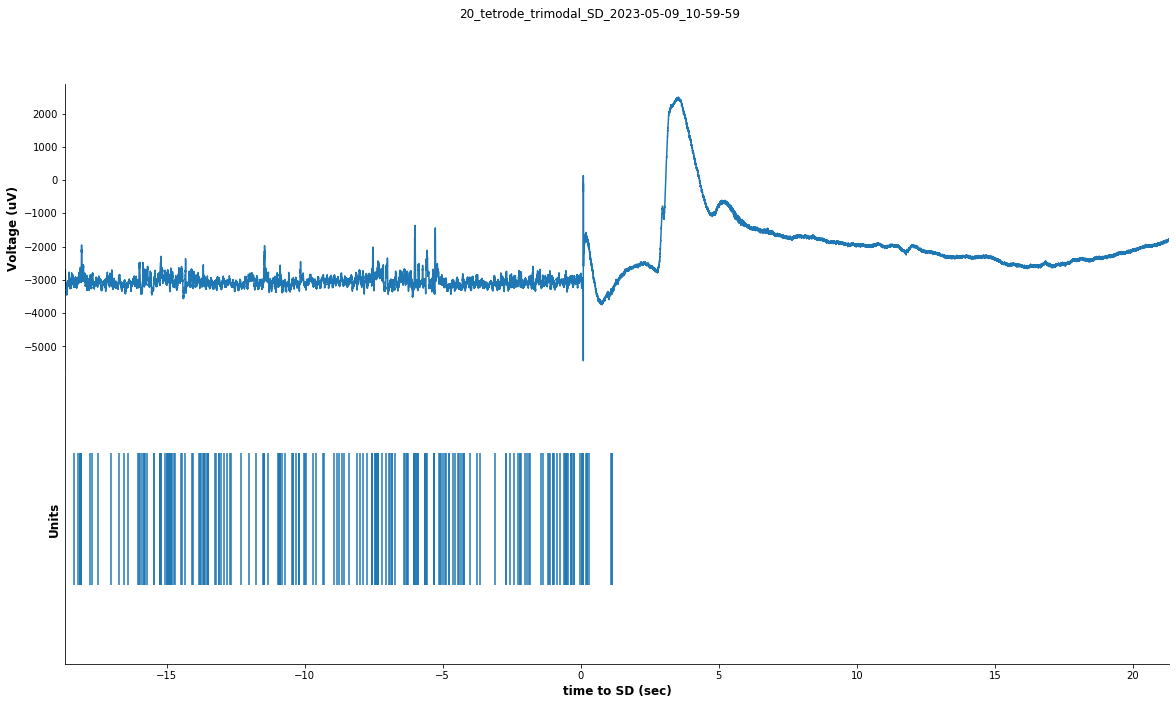

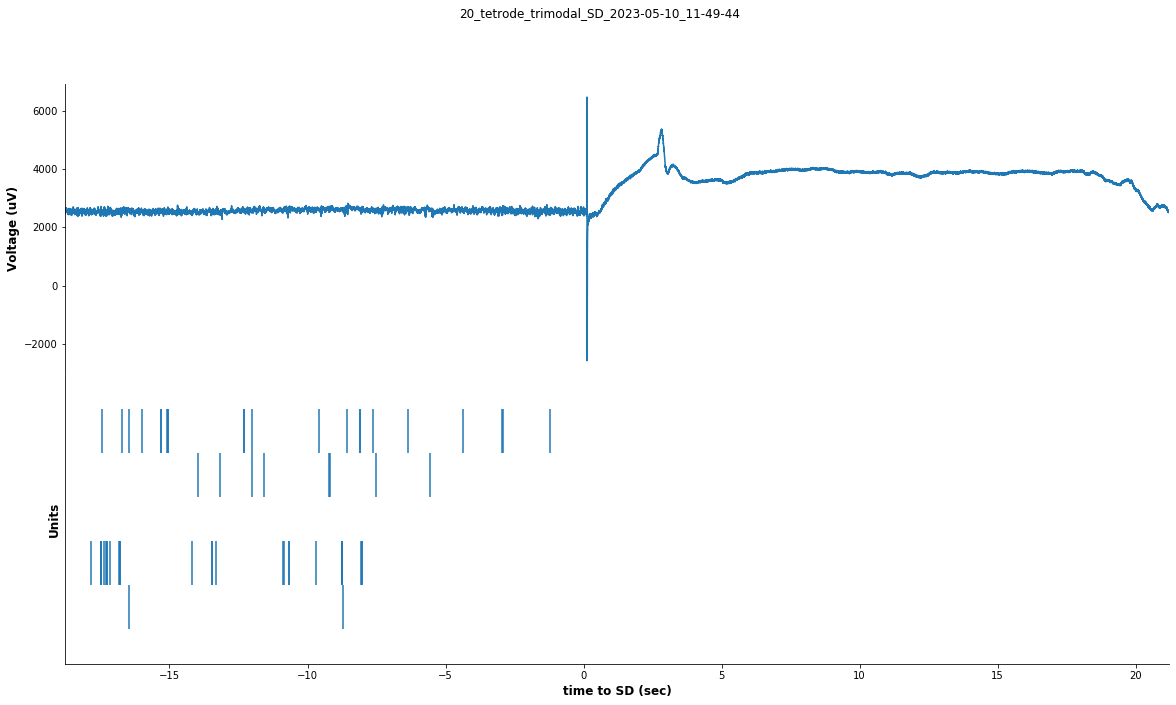

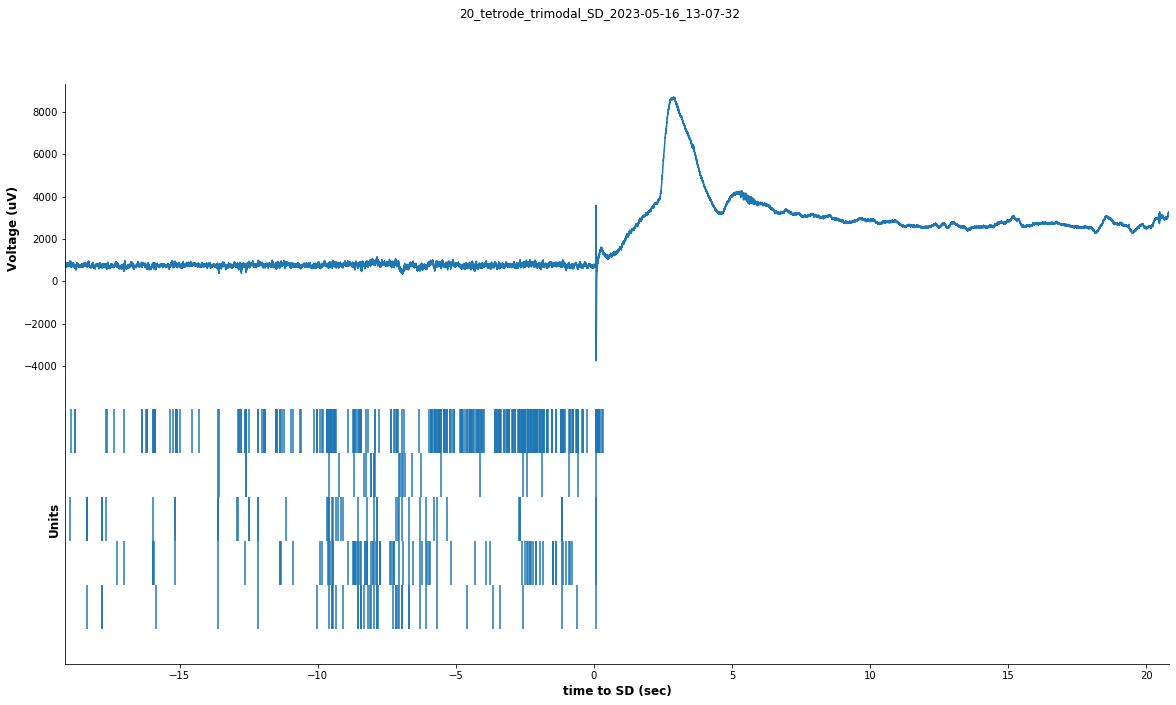

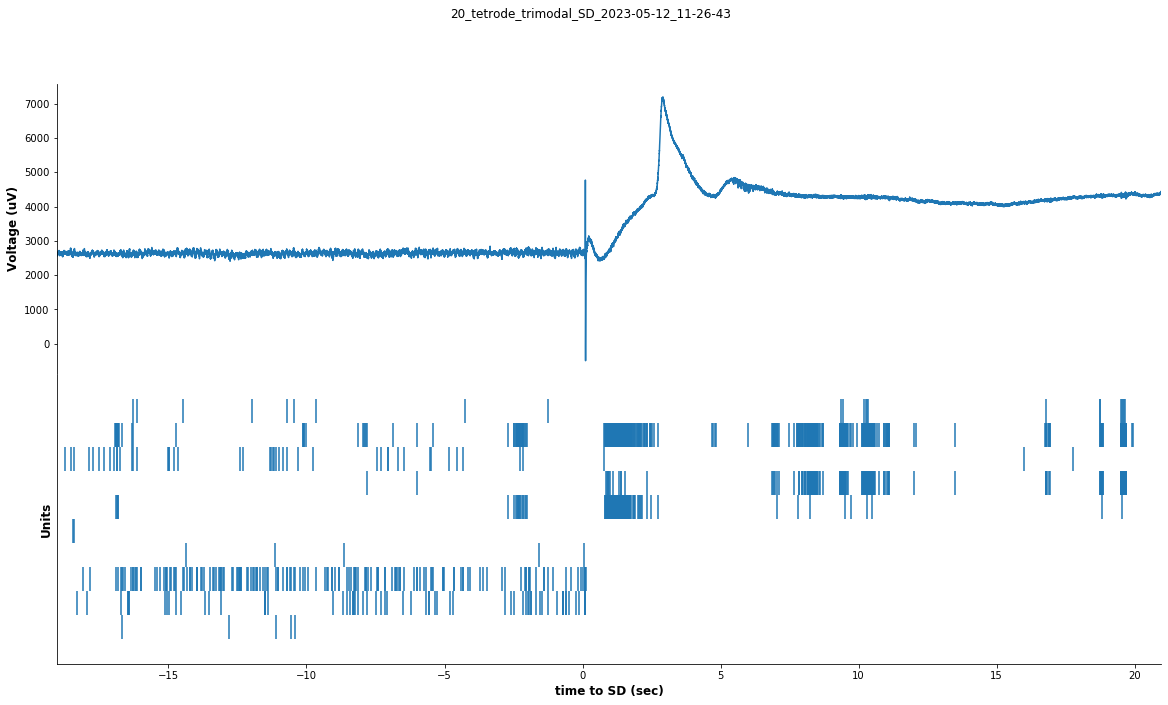

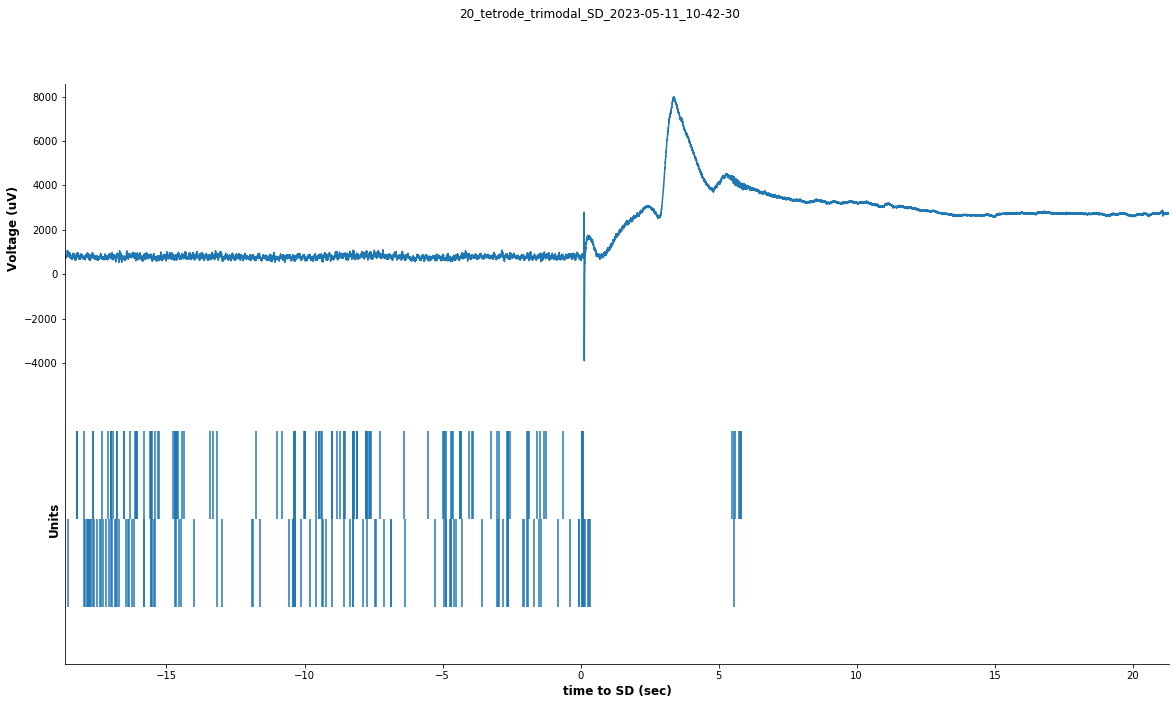

In [61]:
tetrode_path = '/media/Seizures/Wenzel/mouse_tetrode/'
filenames = os.listdir(tetrode_path)

tetrode_filenames = [x for x in filenames if x.endswith('.mat')]

for f in tetrode_filenames:
    #session_name = f
    sdmat = loadmat(os.path.join(tetrode_path, f))
    
    lfp = sdmat['LFP'].T.tolist()[0]
    ts = sdmat['LFP_ts'].T.tolist()[0]
    sd_index = sdmat['binSD'].T.tolist()[0][0]
    matrix = [sdmat['ts'].T.tolist()[x][0].T.tolist()[0] for x, val in enumerate(sdmat['ts'].T.tolist())]
    
    
    sec_before = 20

    sec_after = 20
    #session_name = 

    my_dpi = 96
    #fig = plt.figure(figsize=(1900/my_dpi, 1024/my_dpi))
    fig, ax = plt.subplots(2,1, figsize=(1900/my_dpi, 1024/my_dpi), sharex=True)
    #gs = gridspec.GridSpec(2, 1, height_ratios=[1,2]) 
    #ax2 = plt.subplot(gs[2])
    #ax0 = plt.subplot(gs[0])
    #ax1 = plt.subplot(gs[1], sharex = ax0)



    ax[0].plot(ts[sd_index*2000-sec_before*2000:sd_index*2000+sec_after*2000], 
             lfp[sd_index*2000-sec_before*2000:sd_index*2000+sec_after*2000])
    ax[1].eventplot(matrix)

    ax[1].set_xlim(ts[sd_index*2000-sec_before*2000], ts[sd_index*2000+sec_after*2000])
    #plt.show()

    #ax[0].set_yticks([])
    #ax0.set_xticks([])
    ax[1].set_yticks([])

    ax[1].set_xlabel('time to SD (sec)', fontweight='bold', fontsize=12)

    ax[0].set_ylabel('Voltage (uV)', fontweight='bold', fontsize=12)
    ax[1].set_ylabel('Units', fontweight='bold', fontsize=12)

    ax[0].spines['top'].set_visible(False)
    ax[0].spines['right'].set_visible(False)
    ax[0].spines['bottom'].set_visible(False)
    ax[1].spines['top'].set_visible(False)
    ax[1].spines['right'].set_visible(False)
    #ax[1].spines['bottom'].set_visible(False)

    plt.subplots_adjust(hspace=.0)

    figtitle= f'20_tetrode_trimodal_{f.strip(".mat")}'
    fig.suptitle(figtitle)
    figname = os.path.join(tetrode_path, figtitle)
    
    
    plt.savefig(figname, dpi=300)
    plt.show()

In [486]:
lfp = sdmat['LFP'].T.tolist()[0]
ts = sdmat['LFP_ts'].T.tolist()[0]
sd_index = sdmat['binSD'].T.tolist()[0][0]
matrix = [file['ts'].T.tolist()[x][0].T.tolist()[0] for x, val in enumerate(file['ts'].T.tolist())]

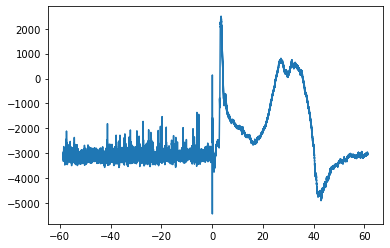

In [487]:
sec_before = 60
sec_after = 60

plt.plot(ts[sd_index*2000-sec_before*2000:sd_index*2000+sec_after*2000],
         lfp[sd_index*2000-sec_before*2000:sd_index*2000+sec_after*2000])
plt.show()

In [9]:
#tetrode_path = '/media/Seizures/Wenzel/mouse_tetrode/'
#tetrode_filenames = os.listdir(tetrode_path)

tetrode_fr = []
tetrode_sd = []
tetrode_spiketimes = []

for f in tetrode_filenames:
    file = loadmat(os.path.join(tetrode_path, f),)
    unit_fr = file['binSpikeRateMtx'].tolist()
    
    
    for ix, unit in enumerate(unit_fr):
        tetrode_fr.append(unit)
        tetrode_sd.append(file['binSD'][0][0])
        tetrode_spiketimes.append(file['ts'].T.tolist()[ix][0].T.tolist()[0])

In [37]:
baselines= [np.nanmean(x[:10*60]) for x in tetrode_fr]

pos_sd_mean = []
pos_sd_mean_norm = []
pre_sd_mean = []
pre_sd_mean_norm = []

time = 60
for ix, sd in enumerate(tetrode_sd):
    pos_sd_mean.append(np.nanmean(tetrode_fr[ix][sd:sd+time]))
    pre_sd_mean.append(np.nanmean(tetrode_fr[ix][sd-time:sd]))
    pos_sd_mean_norm.append(np.round(pos_sd_mean[ix]/baselines[ix]))
    pre_sd_mean_norm.append(np.round(pre_sd_mean[ix]/baselines[ix]))

In [38]:
diff_prepos = [b-a for a, b in zip(pre_sd_mean, pos_sd_mean)]
diff_prepos_norm = [b-a for a, b in zip(pre_sd_mean_norm, pos_sd_mean_norm)]

In [39]:
increase= 0
decrease=0
no_change=0
for x in diff_prepos:
    if x <0:
        decrease+=1
    elif x>0:
        increase+=1
    else:
        no_change+=1

print(increase, decrease, no_change)

3 20 0


In [40]:
increase= 0
decrease=0
no_change=0
for x in diff_prepos_norm:
    if x <0:
        decrease+=1
    elif x>0:
        increase+=1
    else:
        no_change+=1

print(increase, decrease, no_change)

3 13 7


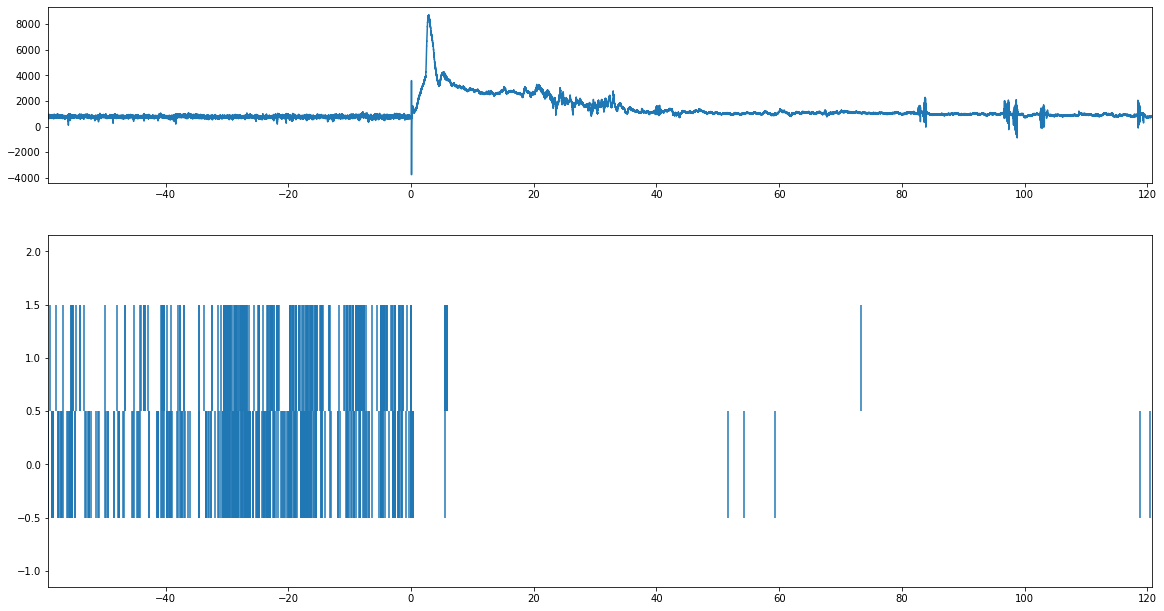

<Figure size 432x288 with 0 Axes>

In [483]:
sec_before = 60

sec_after = 120
session_name = 

my_dpi = 96
fig = plt.figure(figsize=(1900/my_dpi, 1024/my_dpi))
#fig, ax = plt.subplots(3,1, figsize=(1900/my_dpi, 1024/my_dpi))
gs = gridspec.GridSpec(2, 1, height_ratios=[1,2]) 
#ax2 = plt.subplot(gs[2])
ax0 = plt.subplot(gs[0])
ax1 = plt.subplot(gs[1], sharex = ax0)



ax0.plot(ts[sd_index*2000-sec_before*2000:sd_index*2000+sec_after*2000], 
         lfp[sd_index*2000-sec_before*2000:sd_index*2000+sec_after*2000])
ax1.eventplot(matrix)

ax1.set_xlim(ts[sd_index*2000-sec_before*2000], ts[sd_index*2000+sec_after*2000])
plt.show()

ax0.set_yticks([])
#ax0.set_xticks([])
ax1.set_yticks([])

ax1.set_xlabel('time to SD (sec)', fontweight='bold', fontsize=12)

ax0.set_ylabel('Voltage (uV)', fontweight='bold', fontsize=12)
ax1.set_ylabel('Units', fontweight='bold', fontsize=12)

ax0.spines['top'].set_visible(False)
ax0.spines['right'].set_visible(False)
ax0.spines['bottom'].set_visible(False)
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.spines['bottom'].set_visible(False)

plt.subplots_adjust(hspace=.0)

#figtitle= f'tetrode_trimodal_{session_name}'
fig.suptitle(figtitle)
figname = os.path.join(tetrode_path, figtitle)

#plt.savefig(figname, dpi=300)
plt.show()

In [480]:
len(matrix[1])

14635

In [475]:
matrix[0][sd_index-sec_before:sd_index+sec_after]

[-1152.2310269999996,
 -1152.2301269999996,
 -1152.2280269999997,
 -1152.2228269999996,
 -1152.2220269999996,
 -1152.2104269999995,
 -1152.1781269999997,
 -1152.1215269999996,
 -1152.1186269999996,
 -1152.0673269999995,
 -1151.9549269999995,
 -1151.9534269999997,
 -1151.9504269999995,
 -1151.9107269999995,
 -1151.8985269999996,
 -1151.8527269999995,
 -1151.8466269999997,
 -1151.7637269999996,
 -1151.7576269999995,
 -1151.7422269999995,
 -1151.6937269999996,
 -1151.6857269999996,
 -1151.6675269999996,
 -1151.6661269999995,
 -1151.6090269999995,
 -1151.4917269999996,
 -1151.4708269999996,
 -1151.4370269999997,
 -1151.4152269999995,
 -1151.3642269999996,
 -1151.3581269999995,
 -1151.3219269999995,
 -1151.2459269999997,
 -1151.2414269999997,
 -1151.2268269999995,
 -1151.1859269999995,
 -1151.1253269999995,
 -1151.1208269999995,
 -1151.0043269999996,
 -1150.9988269999997,
 -1150.9370269999997,
 -1150.9030269999996,
 -1150.8564269999997,
 -1150.8520269999997,
 -1150.7989269999996,
 -1150.789

In [164]:
def extract_fr_data(path, sz_datetime, sec_before, sec_after, sec_offset_start, sd_regions, period_sec=60, 
                    binsize_ms=1000, min_after_so=25, sec_baseline=10*60, sec_onset_start=(30*60)-10,
                   bl_start=0, unit_type='collapsed'):
    '''extracts the firing rate data from data saved in path. 
    returns a pandas dataframe with binned firing rates
    of baseline, preictal and min_after_so fr/min
    '''
    
    df = pd.DataFrame()
    
    
    #extract data of interest
    chnames = get_chnames(path, strip=True)
    matrix = get_all_spike_times_cluster_info(path, mode=unit_type) #get spikes, collapsed by unit
    regions= get_region_name(path)
    pnr, sznr = get_patinfo_from_path(path) #get patient and seizure number
    
    #transform start and end period to timestamps
    start, end, period = get_start_stop_timestamps(sz_datetime, sec_before, sec_after) 
    
    #get binned firing rates
    binned_fr = get_binned_firingrate(matrix, start, end, binsize_ms)
    
    #populate dataframe
    df['patID'] = [pnr] * len(binned_fr)
    df['seizureID'] = [sznr] * len(binned_fr)
    df['hemisphere'] =  [x[0] for x in chnames]
    df['region'] =  [i[:-1] for i in chnames]
    df['chname'] = chnames
    df['seizureonset'] = [date]*len(binned_fr)
    #for i in sd_regions:
    df['sd'] = df['region'].isin(sd_regions)

    df['firingrate'] = binned_fr
    
    #get mean firing rates for baseline, pre-ictal and 25 min postictal periods (in 1min chunks)
    sec_after_to_try = min_after_so*60 #convert to seconds
    
    #get onsets and offsets of baseline, pre-ictal and all post-ictal periods
    list_of_onsets = [bl_start, sec_onset_start-period_sec] #baseline and pre-ictal onset
    list_of_offsets = [bl_start+sec_baseline, sec_onset_start] #baseline and pre-ictal offsets
    
    onsets = np.arange(sec_offset_start, len(binned_fr[0]), period_sec)
    onsets = onsets[:min_after_so] #cut onsets to min_after_so
    offsets = onsets+period_sec #calculate offsets
    
    list_of_onsets.extend(onsets)
    list_of_offsets.extend(offsets)
    
    #get names of columns to save data into dataframe
    name_cols = ['baseline_mean', 'preictal_mean']
    colums_numbers = np.arange(min_after_so)
    columns = [str(x+1)+'_mean' for x in colums_numbers]
    name_cols.extend(columns)
    
    #calculate mean firing rate falues per period of interest
    for index in range(len(list_of_onsets)):
        #print(index)
        new_col = np.zeros(len(df))
        for ix, row in df['firingrate'].iteritems():
            #print(ix, len(row))
            new_col[ix] = np.nanmean(row[list_of_onsets[index]:list_of_offsets[index]])

        df[name_cols[index]] = new_col
    return df
    
    

In [121]:
csc_channels = match_cssfiles_to_chnames(path)

matfile = loadSpikeData_mat(path, csc_channels[1].strip('.ncs'), details=False)

In [ ]:
groups = get_spike_data_from_matfile()

In [124]:
matfile.get_all_units_times_and_spikes()
matfile.collapse_units_across_type()
len(matfile.SU['times'])

0

In [145]:
def get_all_spike_times_dict(path):
    #Move electrode by electrode, region by region
    #Get all non-artifact spikes and add them to matrix
    #return matirx
    
    #get list of csc channels
    csc_channels = match_cssfiles_to_chnames(path)
    
    #initiate output variable
    matrix = dict()
    
    for i, ch in enumerate(csc_channels):
        #print(f'extracting spikes from {ch}')
        chname = ch.strip('.ncs')
        try:
            matfile = loadSpikeData_mat(path, ch.strip('.ncs'), details=False)
            matfile.get_all_units_times_and_spikes()
            matfile.collapse_units_across_type()

            if len(matfile.collapsed_units['times']):
                matrix[chname] = matfile.collapsed_units['times'][0]
            else:
                matrix[chname] = matfile.collapsed_units['times']
        except (FileNotFoundError, IndexError):
            matric[chname] = []
    return matrix

In [146]:
def cut_spike_data_dict(matrix, so, start_sec, end_sec, scale=1e3):
    '''cuts spike timestamps data from a session 
    between start and end timestamps, as seconds relative
    to seizure onset (so)
    '''
    
    start_ts, end_ts, period = get_start_stop_timestamps(so, start_sec, end_sec)
    
    print(f"cutting {period} seconds starting at {dt.datetime.utcfromtimestamp(start_ts/1e6)}")
    #print(start_ts, end_ts)
    
    out = dict()
    for key, val in matrix.items():
        #print(min(row), max(row), start_ts/1e3, end_ts/1e3)
        #print(dt.datetime.utcfromtimestamp(min(row)/1e3), dt.datetime.utcfromtimestamp(max(row)/1e3))
        cut_data = [x for x in val if x>= start_ts/scale and x<= end_ts/scale]
        out[key] = cut_data
    
    return out

In [156]:
def get_binned_firingrate_dict(data, start, stop, binsize=10, scale=1e3):
    '''calculates binned firing rate
    of data with a binned window
    data must be a list of lists
    window an np.array()
    '''
    
    window = get_fr_binned_window(start, stop, binsize=binsize, scale=scale)
    
    output = dict()
    for key, val in data.items():
        #multiply data by a scale
        scaled_lst = np.multiply(val, scale)
        
        if len(scaled_lst):
            #get histogram
            hist = np.histogram(scaled_lst, window)[0]
        else:
            hist = np.empty(len(window)-1)
            hist[:] = np.nan
        
        output[key] = hist
    
    return output

In [313]:
def cut_firingrates_dict(df_data, binsize, offset, period, key_list=None, mode='sec'):
    '''binsize in ms
    offset and period in sec
    '''
    
    
    
    #Transform offset and period to bins
    sr = get_binned_firingrates_sf(binsize, mode=mode)
    
    
    end = offset+period #in seconds
    
    o = int(offset*sr)
    p = int(end*sr)
    
    print(o,p)
    #print(list(df_data.keys()))
    if not key_list:
        #df_out = dict()
        key_list = list(df_data.keys())
    df_out = {k : None for k in key_list}
    
    for key, val in df_out.items():
        assert p <= len(df_data[key])
        
        df_out[key] = df_data[key][o:p]
    return df_out

In [388]:
path = '/media/Seizures/60min_cut/092/2021-09-21_08-52-50'
pnr, sznr = get_patinfo_from_path(path)
sec_before=-30*60
sec_after=30*60
date = '2021-09-21_09-22-50'
binsize=1000

mx = get_all_spike_times_dict(path)
out = cut_spike_data_dict(mx, date, sec_before, sec_after)
start, end, period = get_start_stop_timestamps(date, sec_before, sec_after) 
tt = get_binned_firingrate_dict(out, start, end, binsize=binsize)
dict_out = cut_firingrates_dict(tt, binsize=binsize, offset=sec_offset_start, period=60, mode='sec')
#dict_out = cut_firingrates_dict(tt, binsize=binsize, offset=10*60, period=60, mode='sec')

cutting 3600 seconds starting at 2021-09-21 08:52:50
1900 1960


In [398]:
chnames = get_chnames(path)
csc_fnames = match_cssfiles_to_chnames(path)
reg = get_region_name(path)

In [399]:
reg

{'LA': ['LA1.ncs',
  'LA2.ncs',
  'LA3.ncs',
  'LA4.ncs',
  'LA5.ncs',
  'LA6.ncs',
  'LA7.ncs',
  'LA8.ncs'],
 'LAH': ['LAH1.ncs',
  'LAH2.ncs',
  'LAH3.ncs',
  'LAH4.ncs',
  'LAH5.ncs',
  'LAH6.ncs',
  'LAH7.ncs',
  'LAH8.ncs'],
 'LEC': ['LEC1.ncs',
  'LEC2.ncs',
  'LEC3.ncs',
  'LEC4.ncs',
  'LEC5.ncs',
  'LEC6.ncs',
  'LEC7.ncs',
  'LEC8.ncs'],
 'LMH': ['LMH1.ncs',
  'LMH2.ncs',
  'LMH3.ncs',
  'LMH4.ncs',
  'LMH5.ncs',
  'LMH6.ncs',
  'LMH7.ncs',
  'LMH8.ncs'],
 'LPHC': ['LPHC1.ncs',
  'LPHC2.ncs',
  'LPHC3.ncs',
  'LPHC4.ncs',
  'LPHC5.ncs',
  'LPHC6.ncs',
  'LPHC7.ncs',
  'LPHC8.ncs'],
 'LPIC': ['LPIC1.ncs',
  'LPIC2.ncs',
  'LPIC3.ncs',
  'LPIC4.ncs',
  'LPIC5.ncs',
  'LPIC6.ncs',
  'LPIC7.ncs',
  'LPIC8.ncs'],
 'LTa': ['LTa1.ncs',
  'LTa2.ncs',
  'LTa3.ncs',
  'LTa4.ncs',
  'LTa5.ncs',
  'LTa6.ncs',
  'LTa7.ncs',
  'LTa8.ncs'],
 'LTb': ['LTb1.ncs',
  'LTb2.ncs',
  'LTb3.ncs',
  'LTb4.ncs',
  'LTb5.ncs',
  'LTb6.ncs',
  'LTb7.ncs',
  'LTb8.ncs']}

In [356]:
window = get_fr_binned_window(start, end, binsize=binsize, scale=1e3)

In [395]:
match_cssfiles_to_chnames(path)

['CSC1.ncs',
 'CSC2.ncs',
 'CSC3.ncs',
 'CSC4.ncs',
 'CSC5.ncs',
 'CSC6.ncs',
 'CSC7.ncs',
 'CSC8.ncs',
 'CSC9.ncs',
 'CSC10.ncs',
 'CSC11.ncs',
 'CSC12.ncs',
 'CSC13.ncs',
 'CSC14.ncs',
 'CSC15.ncs',
 'CSC16.ncs',
 'CSC17.ncs',
 'CSC18.ncs',
 'CSC19.ncs',
 'CSC20.ncs',
 'CSC21.ncs',
 'CSC22.ncs',
 'CSC23.ncs',
 'CSC24.ncs',
 'CSC25.ncs',
 'CSC26.ncs',
 'CSC27.ncs',
 'CSC28.ncs',
 'CSC29.ncs',
 'CSC30.ncs',
 'CSC31.ncs',
 'CSC32.ncs',
 'CSC33.ncs',
 'CSC34.ncs',
 'CSC35.ncs',
 'CSC36.ncs',
 'CSC37.ncs',
 'CSC38.ncs',
 'CSC39.ncs',
 'CSC40.ncs',
 'CSC41.ncs',
 'CSC42.ncs',
 'CSC43.ncs',
 'CSC44.ncs',
 'CSC45.ncs',
 'CSC46.ncs',
 'CSC47.ncs',
 'CSC48.ncs',
 'CSC49.ncs',
 'CSC50.ncs',
 'CSC51.ncs',
 'CSC52.ncs',
 'CSC53.ncs',
 'CSC54.ncs',
 'CSC55.ncs',
 'CSC56.ncs',
 'CSC57.ncs',
 'CSC58.ncs',
 'CSC59.ncs',
 'CSC60.ncs',
 'CSC61.ncs',
 'CSC62.ncs',
 'CSC63.ncs',
 'CSC64.ncs']

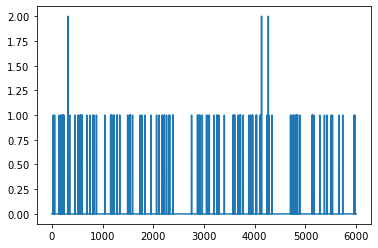

In [379]:
test_ch = dict_out['CSC10']
plt.plot(test_ch)

In [354]:
hist, bins = np.histogram(np.multiply(test_ch, 1e3), bins=window)

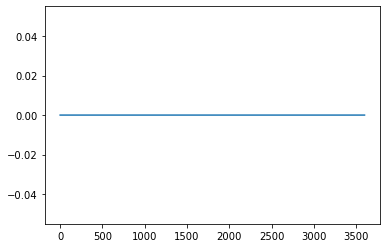

In [355]:
plt.plot(hist)
plt.show()

In [287]:
len(hist)

3599

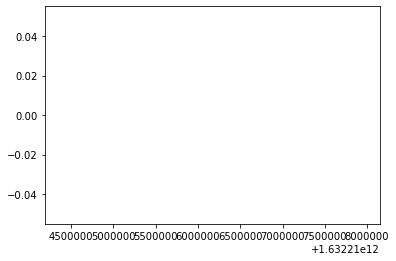

In [357]:
plt.hist(test_ch, bins=60*60, range=[start/1000, end/1000])
plt.show()

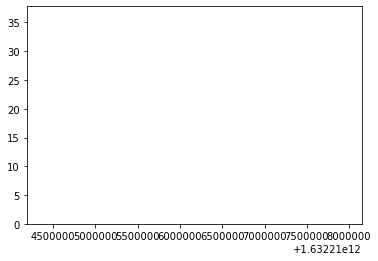

In [267]:
plt.bar(bins[:-1], hist)
plt.show()

In [227]:
df_out = dict()

In [229]:
df_out.keys() = tt.keys()

SyntaxError: cannot assign to function call (2024712066.py, line 1)

In [364]:
dict_out = cut_firingrates_dict(tt, binsize=1000, offset=sec_offset_start, period=60, mode='sec')

1900 1960


In [365]:
dict_out

{'CSC1': array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
 'CSC2': array([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan]),
 'CSC3': array([0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
 'CSC4': array([0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
        0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
 'CSC5':

In [126]:
bl_indices = np.array_split(np.arange(0,60*20*1000), 20)
bl_idx_choices = np.random.choice(np.arange(len(bl_indices)), size=10, replace=True)

array([480000, 480001, 480002, ..., 539997, 539998, 539999])

In [111]:
start, end, period = get_start_stop_timestamps(date, sec_before, sec_after)
binned_fr = get_binned_firingrate(matrix, start, end, binsize)

In [112]:
binned_fr

[array([1, 1, 0, ..., 0, 1, 0]),
 array([nan, nan, nan, ..., nan, nan, nan]),
 array([2, 1, 5, ..., 0, 1, 2]),
 array([0, 0, 0, ..., 0, 0, 0]),
 array([7, 2, 8, ..., 8, 4, 9]),
 array([nan, nan, nan, ..., nan, nan, nan]),
 array([2, 2, 0, ..., 0, 4, 3]),
 array([nan, nan, nan, ..., nan, nan, nan]),
 array([ 4, 13,  8, ...,  1,  4,  4]),
 array([0, 2, 0, ..., 3, 0, 0]),
 array([nan, nan, nan, ..., nan, nan, nan]),
 array([nan, nan, nan, ..., nan, nan, nan]),
 array([1, 0, 0, ..., 0, 0, 0]),
 array([nan, nan, nan, ..., nan, nan, nan]),
 array([nan, nan, nan, ..., nan, nan, nan]),
 array([nan, nan, nan, ..., nan, nan, nan]),
 array([1, 0, 0, ..., 0, 0, 0]),
 array([nan, nan, nan, ..., nan, nan, nan]),
 array([nan, nan, nan, ..., nan, nan, nan]),
 array([nan, nan, nan, ..., nan, nan, nan]),
 array([nan, nan, nan, ..., nan, nan, nan]),
 array([1, 2, 1, ..., 1, 2, 2]),
 array([nan, nan, nan, ..., nan, nan, nan]),
 array([nan, nan, nan, ..., nan, nan, nan]),
 array([nan, nan, nan, ..., nan, n

### Extract data

#### p. 92, s03

In [165]:
path = '/media/Seizures/60min_cut/092/2021-09-21_08-52-50'
pnr, sznr = get_patinfo_from_path(path)
sec_before=-30*60
sec_after=30*60
date = '2021-09-21_09-22-50'
sec_baseline = 10*60
sec_offset_start = (31*60)+20
min_after_so_to_try = 25
binsize=1000
sd_regions = ['LAH', 'LMH']

df_extract = extract_fr_data(path, date, sec_before, sec_after, sec_offset_start, sd_regions)

extracting spikes from CSC1.ncs
extracting spikes from CSC2.ncs
extracting spikes from CSC3.ncs
extracting spikes from CSC4.ncs
extracting spikes from CSC5.ncs
extracting spikes from CSC6.ncs
extracting spikes from CSC7.ncs
extracting spikes from CSC8.ncs
extracting spikes from CSC9.ncs
extracting spikes from CSC10.ncs
extracting spikes from CSC11.ncs
extracting spikes from CSC12.ncs
extracting spikes from CSC13.ncs
extracting spikes from CSC14.ncs
extracting spikes from CSC15.ncs
extracting spikes from CSC16.ncs
extracting spikes from CSC17.ncs
extracting spikes from CSC18.ncs
extracting spikes from CSC19.ncs
extracting spikes from CSC20.ncs
extracting spikes from CSC21.ncs
extracting spikes from CSC22.ncs
extracting spikes from CSC23.ncs
extracting spikes from CSC24.ncs
extracting spikes from CSC25.ncs
extracting spikes from CSC26.ncs
extracting spikes from CSC27.ncs
extracting spikes from CSC28.ncs
extracting spikes from CSC29.ncs
extracting spikes from CSC30.ncs
extracting spikes f

/tmp/ipykernel_8141/2865742774.py:62: RuntimeWarning: Mean of empty slice
  new_col[ix] = np.nanmean(row[list_of_onsets[index]:list_of_offsets[index]])
/tmp/ipykernel_8141/2865742774.py:62: RuntimeWarning: Mean of empty slice
  new_col[ix] = np.nanmean(row[list_of_onsets[index]:list_of_offsets[index]])
/tmp/ipykernel_8141/2865742774.py:62: RuntimeWarning: Mean of empty slice
  new_col[ix] = np.nanmean(row[list_of_onsets[index]:list_of_offsets[index]])
/tmp/ipykernel_8141/2865742774.py:62: RuntimeWarning: Mean of empty slice
  new_col[ix] = np.nanmean(row[list_of_onsets[index]:list_of_offsets[index]])
/tmp/ipykernel_8141/2865742774.py:62: RuntimeWarning: Mean of empty slice
  new_col[ix] = np.nanmean(row[list_of_onsets[index]:list_of_offsets[index]])
/tmp/ipykernel_8141/2865742774.py:62: RuntimeWarning: Mean of empty slice
  new_col[ix] = np.nanmean(row[list_of_onsets[index]:list_of_offsets[index]])
/tmp/ipykernel_8141/2865742774.py:62: RuntimeWarning: Mean of empty slice
  new_col[ix] 

In [166]:
#save data
outpath = '/media/Seizures/Wenzel/firing_rate'
fname = f'firingrate_{pnr}_{sznr}_1000mswindow.pkl'
#chnamesDF.to_pickle(os.path.join(outpath, fname), mode='w', index=False)
df_extract.to_pickle(os.path.join(outpath, fname))

#### p. 89, s01

In [167]:
path = '/media/Seizures/60min_cut/089/2021-04-19_03-43-56'
pnr, sznr = get_patinfo_from_path(path)
sec_before=-30*60
sec_after=30*60
date = '2021-04-19_04-13-56'
sec_baseline = 20*60
sec_offset_start = (31*60)-5
min_after_so_to_try = 25
binsize=1000
sd_regions = ['LA', 'LMH']

df_extract = extract_fr_data(path, date, sec_before, sec_after, sec_offset_start, sd_regions,bl_start=10*60)

extracting spikes from CSC1.ncs
extracting spikes from CSC2.ncs
extracting spikes from CSC3.ncs
extracting spikes from CSC4.ncs
extracting spikes from CSC5.ncs
extracting spikes from CSC6.ncs
extracting spikes from CSC7.ncs
extracting spikes from CSC8.ncs
extracting spikes from CSC9.ncs
extracting spikes from CSC10.ncs
extracting spikes from CSC11.ncs
extracting spikes from CSC12.ncs
extracting spikes from CSC13.ncs
extracting spikes from CSC14.ncs
extracting spikes from CSC15.ncs
extracting spikes from CSC16.ncs
extracting spikes from CSC17.ncs
extracting spikes from CSC18.ncs
extracting spikes from CSC19.ncs
extracting spikes from CSC20.ncs
extracting spikes from CSC21.ncs
extracting spikes from CSC22.ncs
extracting spikes from CSC23.ncs
extracting spikes from CSC24.ncs
extracting spikes from CSC25.ncs
extracting spikes from CSC26.ncs
extracting spikes from CSC27.ncs
extracting spikes from CSC28.ncs
extracting spikes from CSC29.ncs
extracting spikes from CSC30.ncs
extracting spikes f

/tmp/ipykernel_8141/2865742774.py:62: RuntimeWarning: Mean of empty slice
  new_col[ix] = np.nanmean(row[list_of_onsets[index]:list_of_offsets[index]])
/tmp/ipykernel_8141/2865742774.py:62: RuntimeWarning: Mean of empty slice
  new_col[ix] = np.nanmean(row[list_of_onsets[index]:list_of_offsets[index]])
/tmp/ipykernel_8141/2865742774.py:62: RuntimeWarning: Mean of empty slice
  new_col[ix] = np.nanmean(row[list_of_onsets[index]:list_of_offsets[index]])
/tmp/ipykernel_8141/2865742774.py:62: RuntimeWarning: Mean of empty slice
  new_col[ix] = np.nanmean(row[list_of_onsets[index]:list_of_offsets[index]])
/tmp/ipykernel_8141/2865742774.py:62: RuntimeWarning: Mean of empty slice
  new_col[ix] = np.nanmean(row[list_of_onsets[index]:list_of_offsets[index]])
/tmp/ipykernel_8141/2865742774.py:62: RuntimeWarning: Mean of empty slice
  new_col[ix] = np.nanmean(row[list_of_onsets[index]:list_of_offsets[index]])
/tmp/ipykernel_8141/2865742774.py:62: RuntimeWarning: Mean of empty slice
  new_col[ix] 

In [168]:
#save data
outpath = '/media/Seizures/Wenzel/firing_rate'
fname = f'firingrate_{pnr}_{sznr}_1000mswindow.pkl'
#chnamesDF.to_pickle(os.path.join(outpath, fname), mode='w', index=False)
df_extract.to_pickle(os.path.join(outpath, fname))

#### p81, s02

In [169]:
path = '/media/Seizures/60min_cut/081/2019-12-11_17-11-56'
pnr, sznr = get_patinfo_from_path(path)
sec_before=-30*60
sec_after=30*60
date = '2019-12-11_17-41-56'
sec_baseline = 20*60
sec_offset_start = (30*60)+30
min_after_so_to_try = 25
binsize=1000
sd_regions = ['RAH']

df_extract = extract_fr_data(path, date, sec_before, sec_after, sec_offset_start, sd_regions,bl_start=10*60)

extracting spikes from CSC1.ncs
extracting spikes from CSC2.ncs
extracting spikes from CSC3.ncs
extracting spikes from CSC4.ncs
extracting spikes from CSC5.ncs
extracting spikes from CSC6.ncs
extracting spikes from CSC7.ncs
extracting spikes from CSC8.ncs
extracting spikes from CSC9.ncs
extracting spikes from CSC10.ncs
extracting spikes from CSC11.ncs
extracting spikes from CSC12.ncs
extracting spikes from CSC13.ncs
extracting spikes from CSC14.ncs
extracting spikes from CSC15.ncs
extracting spikes from CSC16.ncs
extracting spikes from CSC17.ncs
extracting spikes from CSC18.ncs
extracting spikes from CSC19.ncs
extracting spikes from CSC20.ncs
extracting spikes from CSC21.ncs
extracting spikes from CSC22.ncs
extracting spikes from CSC23.ncs
extracting spikes from CSC24.ncs
extracting spikes from CSC25.ncs
extracting spikes from CSC26.ncs
extracting spikes from CSC27.ncs
extracting spikes from CSC28.ncs
extracting spikes from CSC29.ncs
extracting spikes from CSC30.ncs
extracting spikes f

/tmp/ipykernel_8141/2865742774.py:62: RuntimeWarning: Mean of empty slice
  new_col[ix] = np.nanmean(row[list_of_onsets[index]:list_of_offsets[index]])
/tmp/ipykernel_8141/2865742774.py:62: RuntimeWarning: Mean of empty slice
  new_col[ix] = np.nanmean(row[list_of_onsets[index]:list_of_offsets[index]])
/tmp/ipykernel_8141/2865742774.py:62: RuntimeWarning: Mean of empty slice
  new_col[ix] = np.nanmean(row[list_of_onsets[index]:list_of_offsets[index]])
/tmp/ipykernel_8141/2865742774.py:62: RuntimeWarning: Mean of empty slice
  new_col[ix] = np.nanmean(row[list_of_onsets[index]:list_of_offsets[index]])
/tmp/ipykernel_8141/2865742774.py:62: RuntimeWarning: Mean of empty slice
  new_col[ix] = np.nanmean(row[list_of_onsets[index]:list_of_offsets[index]])
/tmp/ipykernel_8141/2865742774.py:62: RuntimeWarning: Mean of empty slice
  new_col[ix] = np.nanmean(row[list_of_onsets[index]:list_of_offsets[index]])
/tmp/ipykernel_8141/2865742774.py:62: RuntimeWarning: Mean of empty slice
  new_col[ix] 

In [170]:
#save data
outpath = '/media/Seizures/Wenzel/firing_rate'
fname = f'firingrate_{pnr}_{sznr}_1000mswindow.pkl'
#chnamesDF.to_pickle(os.path.join(outpath, fname), mode='w', index=False)
df_extract.to_pickle(os.path.join(outpath, fname))

#### p74, s03

In [171]:
path = '/media/Seizures/60min_cut/074/2019-06-29_10-52-29/'
pnr, sznr = get_patinfo_from_path(path)
sec_before=-30*60
sec_after=30*60
date = '2019-06-29_11-22-29'
sec_baseline = 20*60
sec_offset_start = (36*60)+31
min_after_so_to_try = 25
binsize=1000
sd_regions = ['RA', 'RAH']

df_extract = extract_fr_data(path, date, sec_before, sec_after, sec_offset_start, sd_regions,bl_start=10*60)

extracting spikes from CSC1.ncs
extracting spikes from CSC2.ncs
extracting spikes from CSC3.ncs
extracting spikes from CSC4.ncs
extracting spikes from CSC5.ncs
extracting spikes from CSC6.ncs
extracting spikes from CSC7.ncs
extracting spikes from CSC8.ncs
extracting spikes from CSC9.ncs
extracting spikes from CSC10.ncs
extracting spikes from CSC11.ncs
extracting spikes from CSC12.ncs
extracting spikes from CSC13.ncs
extracting spikes from CSC14.ncs
extracting spikes from CSC15.ncs
extracting spikes from CSC16.ncs
extracting spikes from CSC17.ncs
extracting spikes from CSC18.ncs
extracting spikes from CSC19.ncs
extracting spikes from CSC20.ncs
extracting spikes from CSC21.ncs
extracting spikes from CSC22.ncs
extracting spikes from CSC23.ncs
extracting spikes from CSC24.ncs
extracting spikes from CSC25.ncs
extracting spikes from CSC26.ncs
extracting spikes from CSC27.ncs
extracting spikes from CSC28.ncs
extracting spikes from CSC29.ncs
extracting spikes from CSC30.ncs
extracting spikes f

/tmp/ipykernel_8141/2865742774.py:62: RuntimeWarning: Mean of empty slice
  new_col[ix] = np.nanmean(row[list_of_onsets[index]:list_of_offsets[index]])
/tmp/ipykernel_8141/2865742774.py:62: RuntimeWarning: Mean of empty slice
  new_col[ix] = np.nanmean(row[list_of_onsets[index]:list_of_offsets[index]])
/tmp/ipykernel_8141/2865742774.py:62: RuntimeWarning: Mean of empty slice
  new_col[ix] = np.nanmean(row[list_of_onsets[index]:list_of_offsets[index]])
/tmp/ipykernel_8141/2865742774.py:62: RuntimeWarning: Mean of empty slice
  new_col[ix] = np.nanmean(row[list_of_onsets[index]:list_of_offsets[index]])
/tmp/ipykernel_8141/2865742774.py:62: RuntimeWarning: Mean of empty slice
  new_col[ix] = np.nanmean(row[list_of_onsets[index]:list_of_offsets[index]])
/tmp/ipykernel_8141/2865742774.py:62: RuntimeWarning: Mean of empty slice
  new_col[ix] = np.nanmean(row[list_of_onsets[index]:list_of_offsets[index]])
/tmp/ipykernel_8141/2865742774.py:62: RuntimeWarning: Mean of empty slice
  new_col[ix] 

In [172]:
#save data
outpath = '/media/Seizures/Wenzel/firing_rate'
fname = f'firingrate_{pnr}_{sznr}_1000mswindow.pkl'
#chnamesDF.to_pickle(os.path.join(outpath, fname), mode='w', index=False)
df_extract.to_pickle(os.path.join(outpath, fname))

#### p100, s04

In [173]:
path = '/media/Seizures/60min_cut/100/2023-04-22_00-10-43/'
pnr, sznr = get_patinfo_from_path(path)
sec_before=-30*60
sec_after=30*60
date = '2023-04-22_00-40-43'
sec_baseline = 20*60
sec_offset_start = (31*60)+40
min_after_so_to_try = 25
binsize=1000
sd_regions = ['LAH', 'LEC']

df_extract = extract_fr_data(path, date, sec_before, sec_after, sec_offset_start, sd_regions,bl_start=10*60)

extracting spikes from CSC1.ncs
extracting spikes from CSC2.ncs
extracting spikes from CSC3.ncs
extracting spikes from CSC4.ncs
extracting spikes from CSC5.ncs
extracting spikes from CSC6.ncs
extracting spikes from CSC7.ncs
extracting spikes from CSC8.ncs
extracting spikes from CSC9.ncs
extracting spikes from CSC10.ncs
extracting spikes from CSC11.ncs
extracting spikes from CSC12.ncs
extracting spikes from CSC13.ncs
extracting spikes from CSC14.ncs
extracting spikes from CSC15.ncs
extracting spikes from CSC16.ncs
extracting spikes from CSC17.ncs
extracting spikes from CSC18.ncs
extracting spikes from CSC19.ncs
extracting spikes from CSC20.ncs
extracting spikes from CSC21.ncs
extracting spikes from CSC22.ncs
extracting spikes from CSC23.ncs
extracting spikes from CSC24.ncs
extracting spikes from CSC25.ncs
extracting spikes from CSC26.ncs
extracting spikes from CSC27.ncs
extracting spikes from CSC28.ncs
extracting spikes from CSC29.ncs
extracting spikes from CSC30.ncs
extracting spikes f

/tmp/ipykernel_8141/2865742774.py:62: RuntimeWarning: Mean of empty slice
  new_col[ix] = np.nanmean(row[list_of_onsets[index]:list_of_offsets[index]])
/tmp/ipykernel_8141/2865742774.py:62: RuntimeWarning: Mean of empty slice
  new_col[ix] = np.nanmean(row[list_of_onsets[index]:list_of_offsets[index]])
/tmp/ipykernel_8141/2865742774.py:62: RuntimeWarning: Mean of empty slice
  new_col[ix] = np.nanmean(row[list_of_onsets[index]:list_of_offsets[index]])
/tmp/ipykernel_8141/2865742774.py:62: RuntimeWarning: Mean of empty slice
  new_col[ix] = np.nanmean(row[list_of_onsets[index]:list_of_offsets[index]])
/tmp/ipykernel_8141/2865742774.py:62: RuntimeWarning: Mean of empty slice
  new_col[ix] = np.nanmean(row[list_of_onsets[index]:list_of_offsets[index]])
/tmp/ipykernel_8141/2865742774.py:62: RuntimeWarning: Mean of empty slice
  new_col[ix] = np.nanmean(row[list_of_onsets[index]:list_of_offsets[index]])
/tmp/ipykernel_8141/2865742774.py:62: RuntimeWarning: Mean of empty slice
  new_col[ix] 

In [174]:
#save data
outpath = '/media/Seizures/Wenzel/firing_rate'
fname = f'firingrate_{pnr}_{sznr}_1000mswindow.pkl'
#chnamesDF.to_pickle(os.path.join(outpath, fname), mode='w', index=False)
df_extract.to_pickle(os.path.join(outpath, fname))

### Read the data

In [175]:
outpath = '/media/Seizures/Wenzel/firing_rate'
files = glob.glob(os.path.join(outpath,'*.pkl'))
#pnr, sznr = get_patinfo_from_path(path)
df = pd.concat([pd.read_pickle(fp) for fp in files], ignore_index=True)

In [176]:
subset = df[['patID','baseline_mean','preictal_mean','1_mean', 'sd', 'region']]

In [177]:
subset.replace([np.inf, -np.inf], np.nan, inplace=True)
subset = subset[subset['baseline_mean'].notna()]

/tmp/ipykernel_8141/3239296425.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset.replace([np.inf, -np.inf], np.nan, inplace=True)


In [178]:
subset['norm_mean_preictal'] = subset['preictal_mean'] / subset['baseline_mean']
#subset['norm_mean_preictal'] = subset['preictal_mean'] - subset['baseline_mean']

/tmp/ipykernel_8141/3359930268.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset['norm_mean_preictal'] = subset['preictal_mean'] / subset['baseline_mean']


In [179]:
subset['norm_mean_posictal'] = subset['1_mean'] / subset['baseline_mean']


/tmp/ipykernel_8141/1391957017.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset['norm_mean_posictal'] = subset['1_mean'] / subset['baseline_mean']


In [180]:
subset['norm_mean_diff'] = subset['norm_mean_posictal'] - subset['norm_mean_preictal']

/tmp/ipykernel_8141/4016697332.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset['norm_mean_diff'] = subset['norm_mean_posictal'] - subset['norm_mean_preictal']


/usr/lib/python3/dist-packages/matplotlib/cbook/__init__.py:1426: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


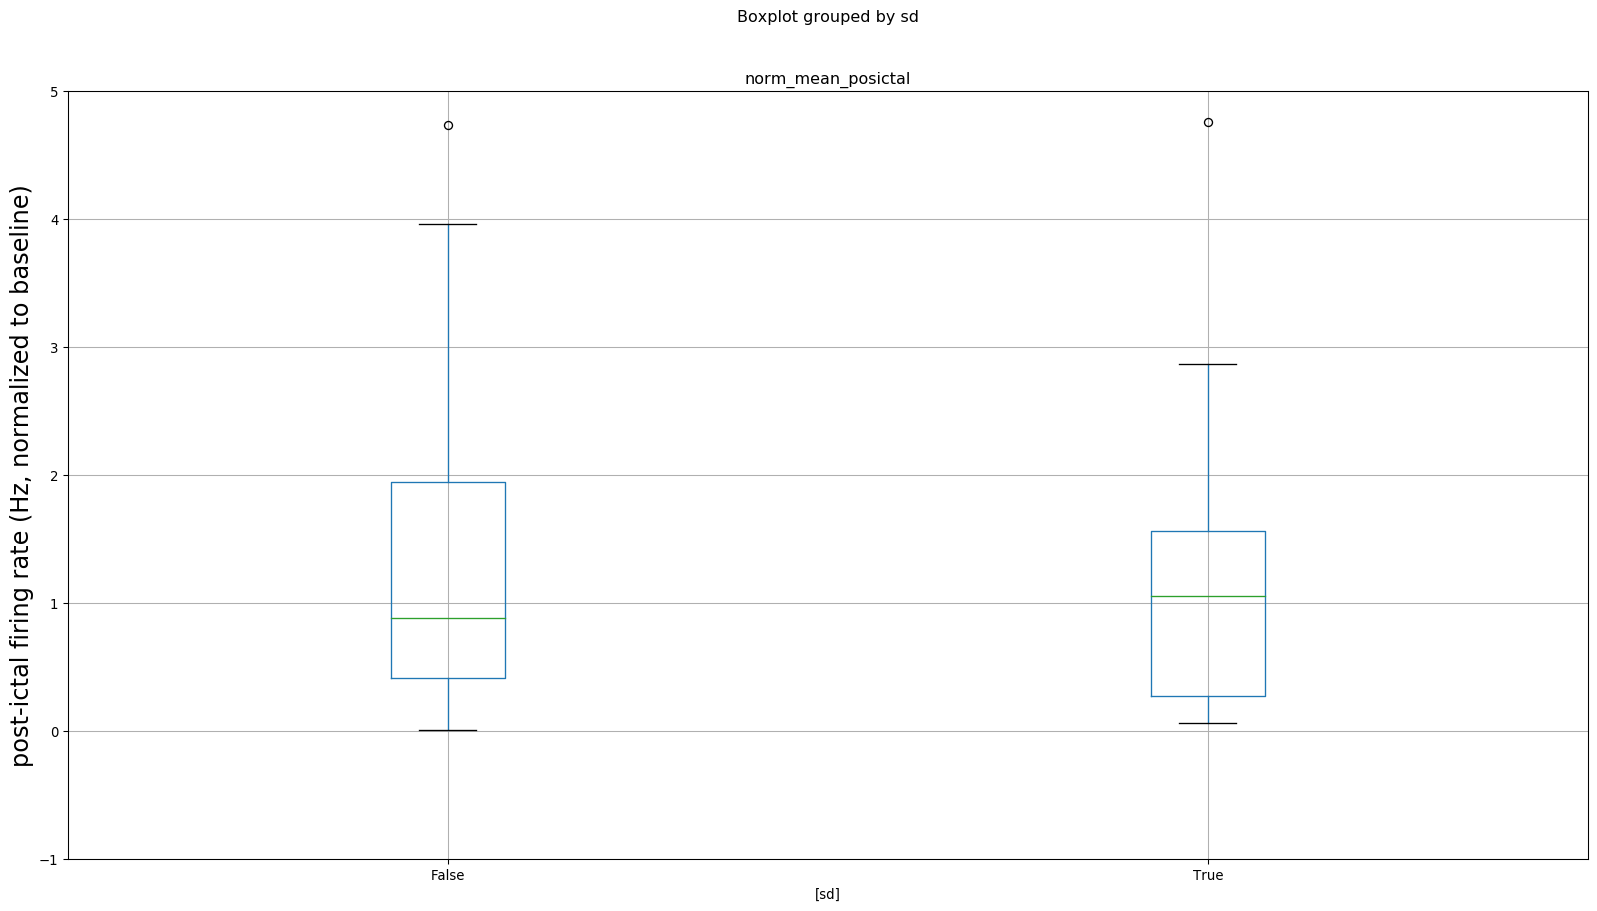

In [181]:
my_dpi = 96
fig, ax = plt.subplots(figsize=(1900/my_dpi, 1024/my_dpi), dpi=my_dpi)
subset.boxplot(column=['norm_mean_posictal'], 
               by=['sd'],  
               ax=ax,
              )
ax.set_ylim(-1,5)
ax.set_ylabel('post-ictal firing rate (Hz, normalized to baseline)', fontsize=18)
plt.show()

NameError: name 'bars' is not defined

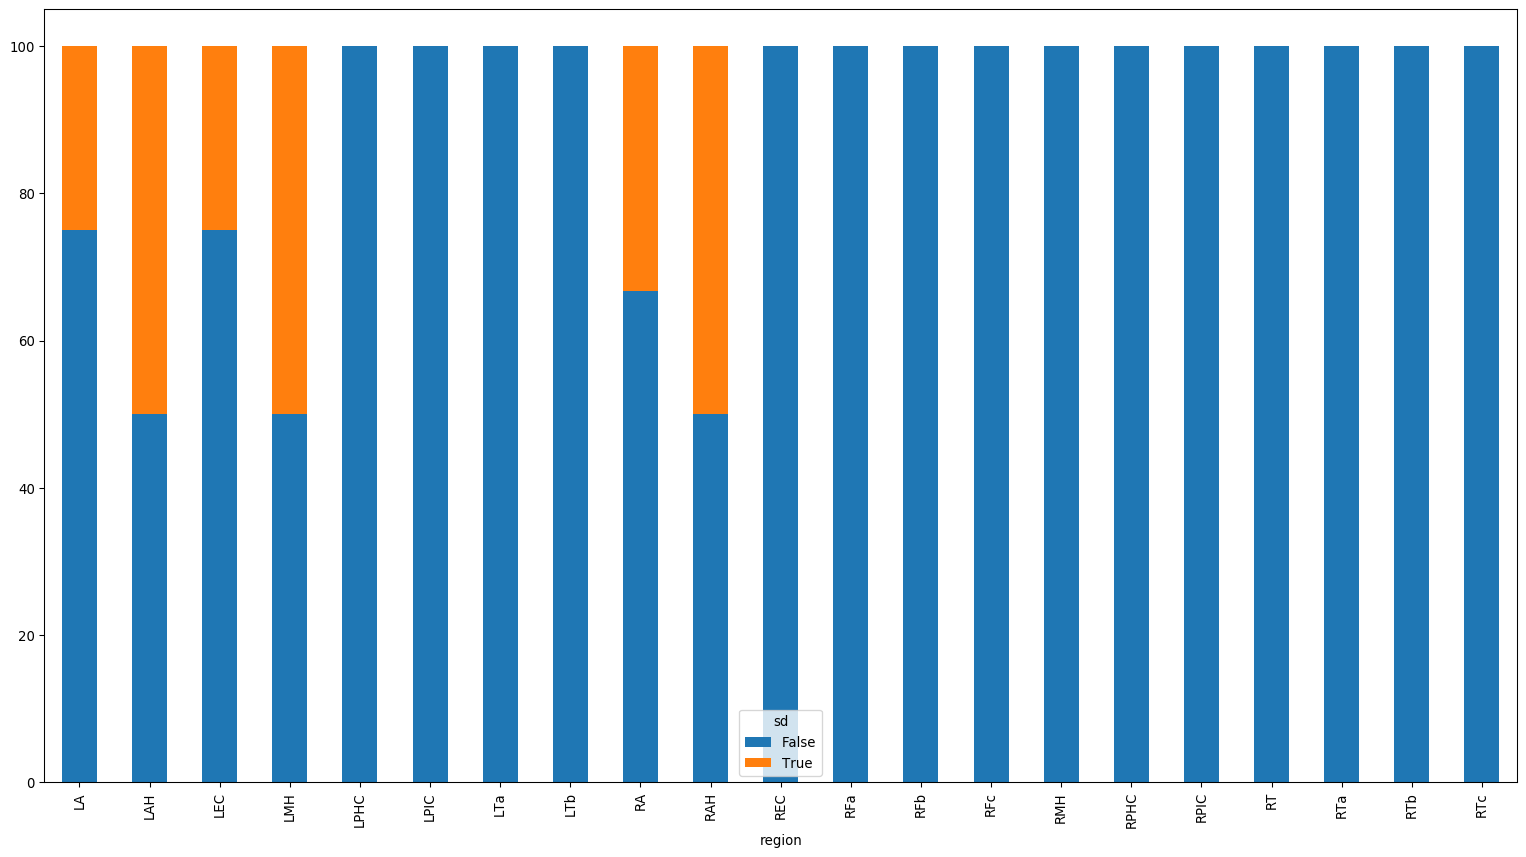

In [77]:
import seaborn as sns
my_dpi = 96
fig, ax = plt.subplots(figsize=(1900/my_dpi, 1024/my_dpi), dpi=my_dpi)
percentage_df = df['sd'].groupby(df['region']).value_counts(normalize=True).unstack().fillna(0) * 100
#subset.boxplot(column=['norm_mean_posictal'], 
#               by=['region'],  
#               ax=ax,
#              )
percentage_df.plot(kind='bar', stacked=True, ax=ax)
#sns.barplot(x='region', y='sd', data=grouped_data)
#ax.set_ylim(-1,5)
#ax.set_ylabel('post-ictal firing rate (Hz, normalized to baseline)', fontsize=18)

for bar in bars.patches:
    yval = bar.get_height()
    ax.text(bar.get_x() + bar.get_width() / 2, yval, round(yval, 2), ha='center', va='bottom')
plt.show()

#grouped_data = df.groupby('group_column')['variable_to_plot'].mean().reset_index()

In [22]:
grouped_data

/usr/lib/python3/dist-packages/matplotlib/cbook/__init__.py:1426: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


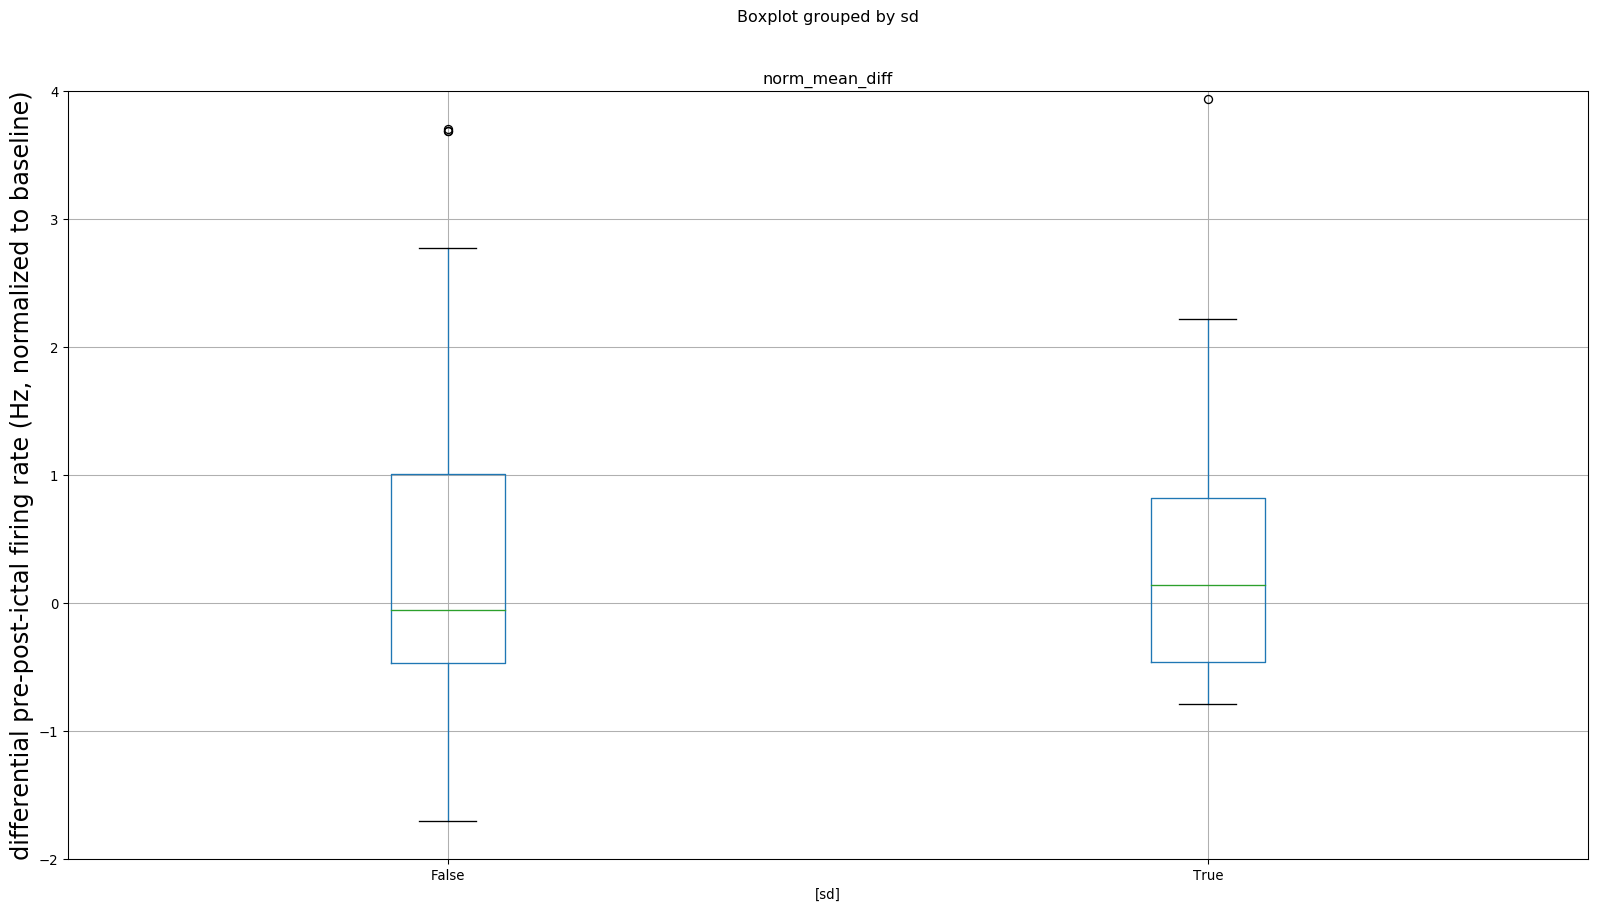

In [78]:
my_dpi = 96
fig, ax = plt.subplots(figsize=(1900/my_dpi, 1024/my_dpi), dpi=my_dpi)
subset.boxplot(column=['norm_mean_diff'], 
               by=['sd'],  
               ax=ax,
              )
ax.set_ylim(-2,4)
ax.set_ylabel('differential pre-post-ictal firing rate (Hz, normalized to baseline)', fontsize=18)
plt.show()

/usr/lib/python3/dist-packages/matplotlib/cbook/__init__.py:1426: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


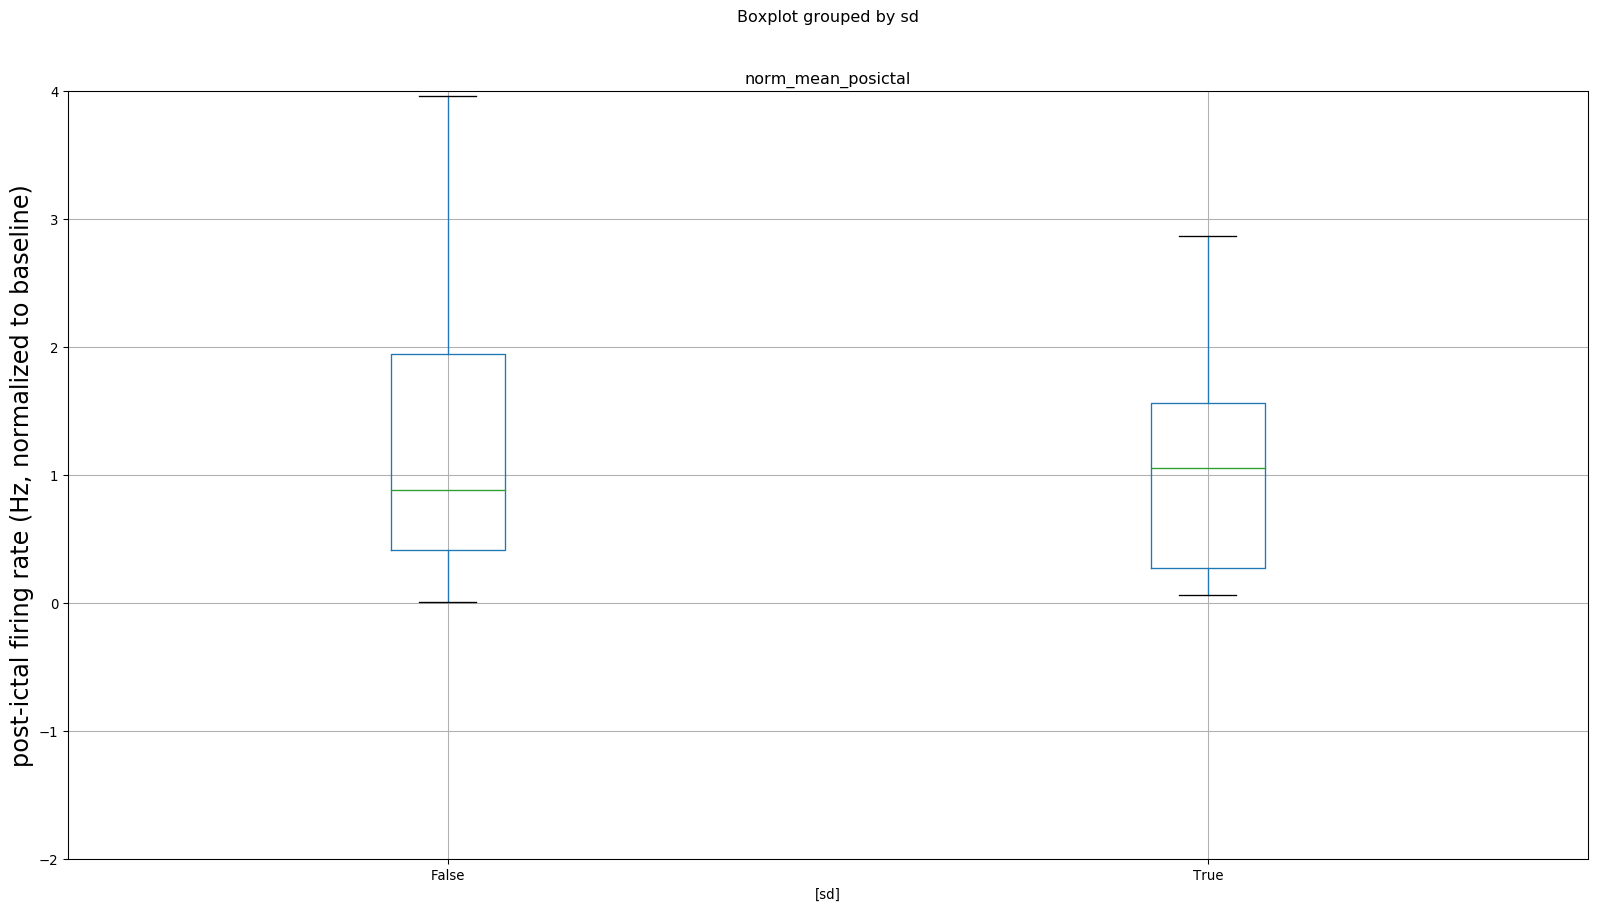

In [79]:
my_dpi = 96
fig, ax = plt.subplots(figsize=(1900/my_dpi, 1024/my_dpi), dpi=my_dpi)
subset.boxplot(column=['norm_mean_posictal'], 
               by=['sd'],  
               ax=ax,
              )
ax.set_ylim(-2,4)
ax.set_ylabel('post-ictal firing rate (Hz, normalized to baseline)', fontsize=18)
plt.show()

/usr/lib/python3/dist-packages/matplotlib/cbook/__init__.py:1426: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


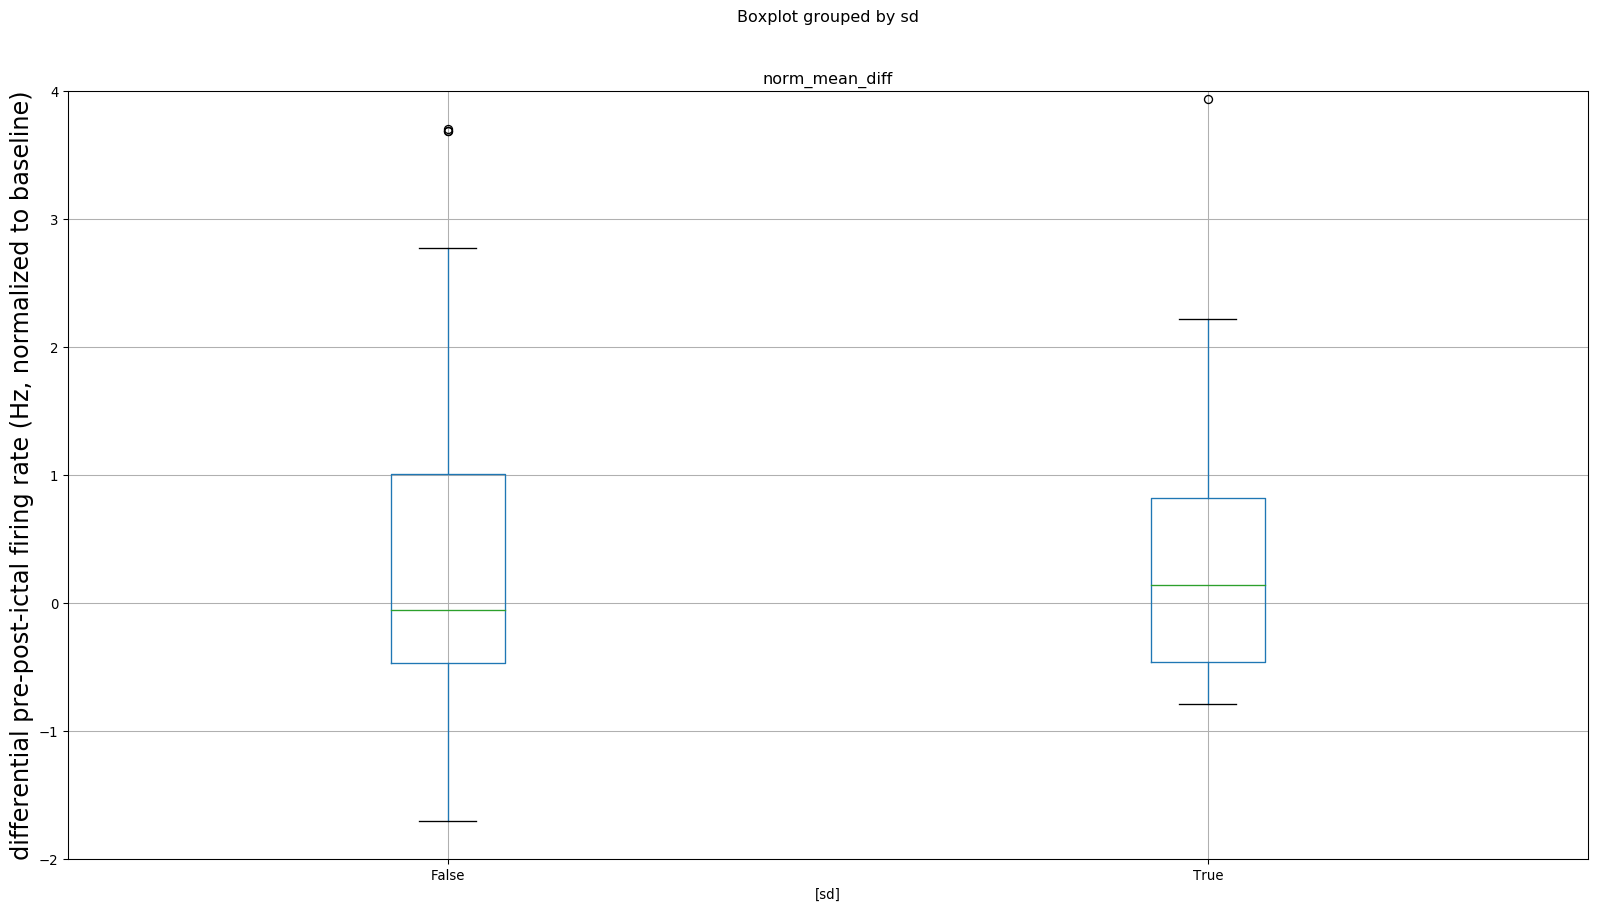

In [80]:
my_dpi = 96
fig, ax = plt.subplots(figsize=(1900/my_dpi, 1024/my_dpi), dpi=my_dpi)
subset.boxplot(column=['norm_mean_diff'], 
               by=['sd'],  
               ax=ax,
              )
ax.set_ylim(-2,4)
ax.set_ylabel('differential pre-post-ictal firing rate (Hz, normalized to baseline)', fontsize=18)
plt.show()

### stats

In [81]:
subset.replace([np.inf, -np.inf], np.nan, inplace=True)
subset = subset[subset['norm_mean_posictal'].notna()]
subset = subset[subset['norm_mean_diff'].notna()]

g1 = subset[subset['sd']==True]
g2 = subset[subset['sd']==False]

In [82]:
stats.ttest_ind(g1.dropna()['norm_mean_posictal'], g2.dropna()['norm_mean_posictal'])

Ttest_indResult(statistic=0.15095385076820242, pvalue=0.880253526701148)

In [83]:
stats.ttest_ind(g1.dropna()['norm_mean_diff'], g2.dropna()['norm_mean_diff'])

Ttest_indResult(statistic=0.39971987899030453, pvalue=0.6900396316972803)

### Try the rate of FR recovery

In [84]:
name_cols = [x for x in df.columns.tolist() if any(char.isdigit() for char in x)]
linear_col_names = ['sd', 'region', 'baseline_mean', 'preictal_mean']
linear_col_names.extend(name_cols)
linear = df[linear_col_names]

In [85]:
linear = linear[linear['baseline_mean'].notna()]

In [400]:
linear[name_cols] = linear[name_cols].div(linear['baseline_mean'], axis=0)
linear[name_cols]

,1_mean,2_mean,3_mean,4_mean,5_mean,6_mean,7_mean,8_mean,9_mean,10_mean,...,16_mean,17_mean,18_mean,19_mean,20_mean,21_mean,22_mean,23_mean,24_mean,25_mean
0,-0.006278,-0.012555,-0.000000,-0.006278,-0.081610,-0.037666,-0.056499,-0.106721,-0.043944,-0.150665,...,-0.156943,-0.703104,-0.998157,-0.521051,-0.263664,-0.307608,-0.213442,-0.263664,-0.765882,-0.527328
2,-0.000543,-0.001629,-0.003258,-0.003801,-0.004345,-0.003983,-0.004164,-0.006336,-0.003620,-0.005250,...,-0.003983,-0.024619,-0.053221,-0.012310,-0.016473,-0.008689,-0.007060,-0.008146,-0.029869,-0.019188
3,-2.979975,-0.993325,-0.496662,-0.496662,-2.483312,-9.436586,-2.483312,-4.469962,-0.993325,-3.476637,...,-1.986650,-29.799746,-77.479339,-27.813096,-13.906548,-0.496662,-2.979975,-1.986650,-23.343134,-23.839797
4,0.000557,0.001237,0.002968,0.005442,0.006431,0.009585,0.012059,0.011131,0.007792,0.009709,...,0.015337,0.019480,0.029869,0.019047,0.021212,0.022758,0.024613,0.024675,0.024798,0.023500
6,-0.013740,-0.003664,-0.010992,-0.024732,-0.042136,-0.037556,-0.040304,-0.052213,-0.047633,-0.045800,...,-0.085189,-0.206102,-0.392968,-0.147478,-0.128241,-0.085189,-0.111753,-0.103509,-0.198774,-0.160302
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
283,-2.100560,-1.326669,-1.087132,-0.755464,-0.414584,-0.644909,-0.700187,-1.105558,-1.142410,-1.142410,...,-1.216113,-1.289817,-1.566207,-1.612272,-1.474077,-2.008430,-1.428012,-1.584633,-1.225326,-1.022641
284,-0.668711,-0.574135,-0.392180,-0.537127,-0.497036,-0.260597,-0.268307,-0.256999,-0.247233,-0.240551,...,-0.180413,-0.224103,-0.221533,-0.226159,-0.232841,-0.226159,-0.236439,-0.222047,-0.170133,-0.211253
285,-2.115155,-2.934777,-1.656871,-1.577553,-2.106342,-2.009397,-2.194473,-2.168034,-2.582251,-2.141594,...,-2.071089,-2.141594,-2.591065,-2.335483,-2.079902,-2.441241,-2.564625,-2.511746,-2.000584,-2.282604
286,2.064958,4.329567,4.295341,1.015366,0.861350,1.135157,1.346216,1.528754,1.637135,1.580092,...,1.517345,1.745517,1.756926,1.562979,1.357625,1.329103,1.334807,1.699883,1.808265,1.688474


In [401]:
only_columns = linear[name_cols[:15]]
linear['A_norm'], linear['B_norm'] = np.polyfit(np.arange(1,len(only_columns.T)+1), only_columns.T, 1)

In [402]:
#Transform norm_baseline to norm_diff_to_preictal
linear['norm_mean_preictal'] = linear['preictal_mean'] - linear['baseline_mean']
linear[name_cols] =  linear[name_cols].div(linear['norm_mean_preictal'], axis=0)
linear[name_cols]

,1_mean,2_mean,3_mean,4_mean,5_mean,6_mean,7_mean,8_mean,9_mean,10_mean,...,16_mean,17_mean,18_mean,19_mean,20_mean,21_mean,22_mean,23_mean,24_mean,25_mean
0,0.015760,0.031520,0.000000,0.015760,0.204879,0.094560,0.141840,0.267919,0.110320,0.378239,...,0.393999,1.765116,2.505834,1.308077,0.661918,0.772238,0.535839,0.661918,1.922715,1.323837
2,0.000227,0.000682,0.001363,0.001591,0.001818,0.001666,0.001742,0.002651,0.001515,0.002197,...,0.001666,0.010301,0.022268,0.005150,0.006893,0.003636,0.002954,0.003408,0.012497,0.008029
3,17.192161,5.730720,2.865360,2.865360,14.326801,54.441843,14.326801,25.788241,5.730720,20.057521,...,11.461441,171.921610,446.996186,160.460169,80.230085,2.865360,17.192161,11.461441,134.671928,137.537288
4,0.000354,0.000787,0.001889,0.003463,0.004092,0.006099,0.007673,0.007083,0.004958,0.006178,...,0.009758,0.012394,0.019005,0.012119,0.013496,0.014480,0.015660,0.015700,0.015778,0.014952
6,0.021413,0.005710,0.017131,0.038544,0.065667,0.058529,0.062812,0.081370,0.074232,0.071377,...,0.132762,0.321198,0.612418,0.229835,0.199857,0.132762,0.174161,0.161313,0.309778,0.249821
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
283,6.178116,3.901968,3.197446,2.221954,1.219365,1.896790,2.059372,3.251640,3.360028,3.360028,...,3.576804,3.793580,4.606490,4.741975,4.335520,5.907146,4.200035,4.660684,3.603901,3.007767
284,1.346398,1.155977,0.789624,1.081465,1.000743,0.524691,0.540215,0.517447,0.497784,0.484331,...,0.363248,0.451214,0.446039,0.455353,0.468807,0.455353,0.476051,0.447074,0.342550,0.425342
285,22.264787,30.892392,17.440750,16.605820,22.172017,21.151547,23.099716,22.821406,27.181594,22.543097,...,21.800937,22.543097,27.274364,24.584035,21.893707,25.697275,26.996054,26.439434,21.058777,24.027416
286,26.934239,56.472616,56.026192,13.243907,11.235000,14.806391,17.559338,19.940265,21.353941,20.609901,...,19.791457,22.767616,22.916424,20.386689,17.708146,17.336126,17.410530,22.172384,23.586060,22.023576


In [89]:
only_columns = linear[name_cols[:15]]
linear['A_diff_norm'], linear['B_diff_norm'] = np.polyfit(np.arange(1,len(only_columns.T)+1), only_columns.T, 1)

In [405]:
linear['time_to_recovery'] =  (linear['norm_mean_preictal']- linear['B_norm'])/linear['A_norm']

In [406]:
linear['time_to_recovery'] 

0         35.757335
2      19434.893225
3         26.294856
4       1567.089849
6        151.669473
           ...     
283      -54.304456
284        2.594745
285     -155.164496
286       37.966675
287    -3739.444516
Name: time_to_recovery, Length: 128, dtype: float64

/usr/lib/python3/dist-packages/matplotlib/cbook/__init__.py:1426: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


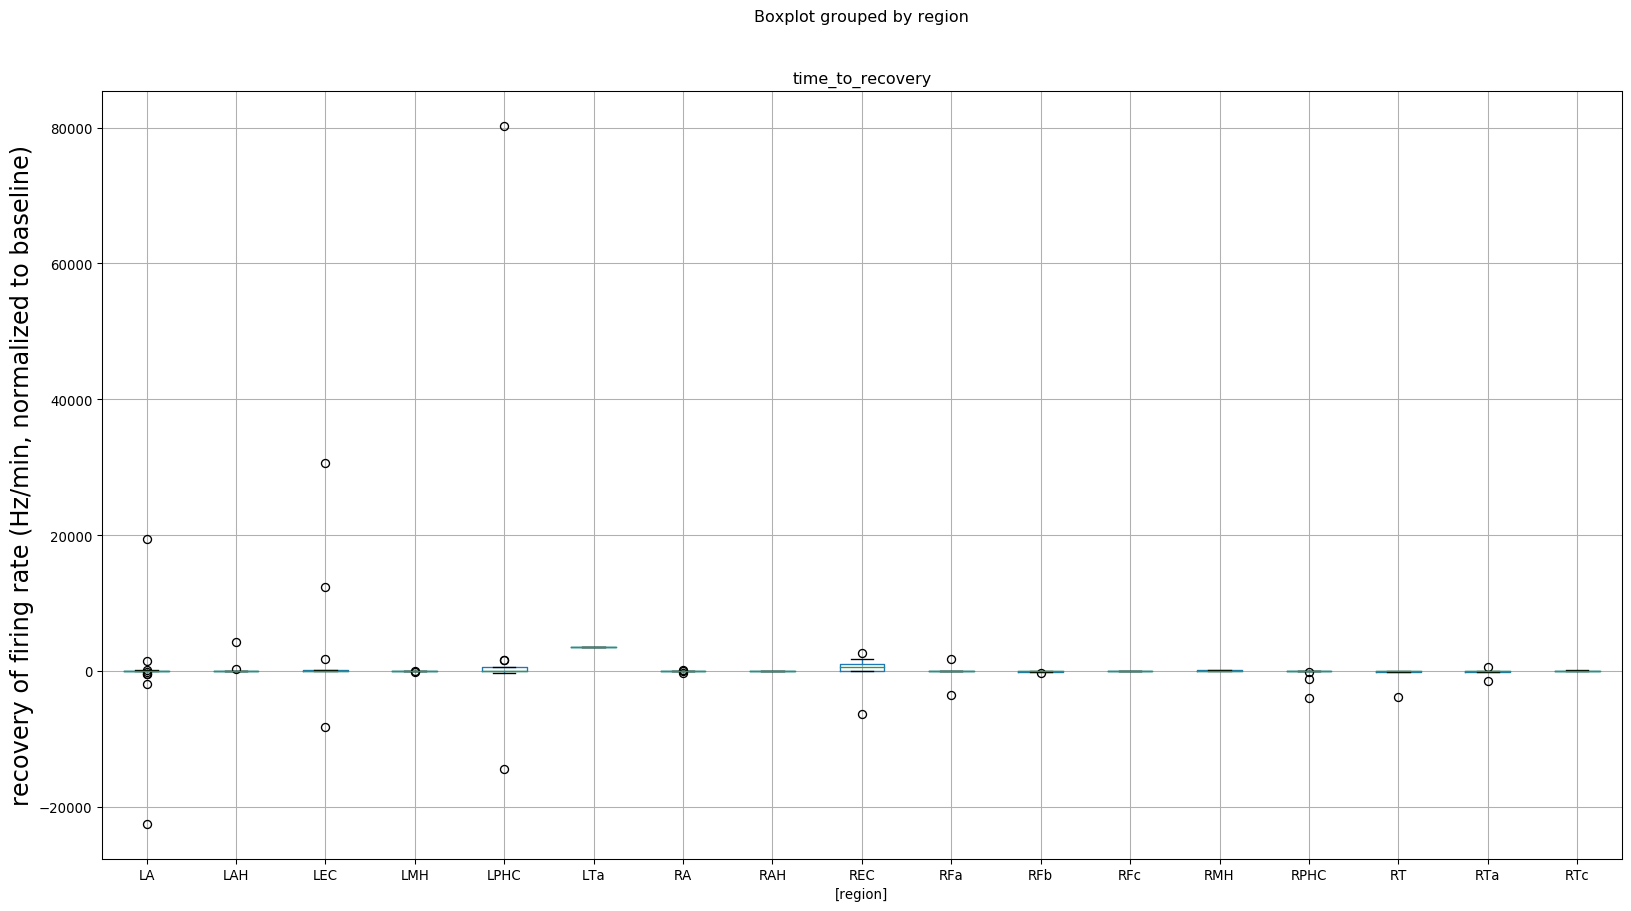

In [407]:
my_dpi = 96
fig, ax = plt.subplots(figsize=(1900/my_dpi, 1024/my_dpi), dpi=my_dpi)
linear.boxplot(column=['time_to_recovery'], 
               by=['region'],  
               ax=ax,
              )
#ax.set_ylim(-1,5)
ax.set_ylabel('recovery of firing rate (Hz/min, normalized to baseline)', fontsize=18)
plt.show()


#boxplot = linear.boxplot(column=['A_norm'], by=['region'] )

/usr/lib/python3/dist-packages/matplotlib/cbook/__init__.py:1426: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


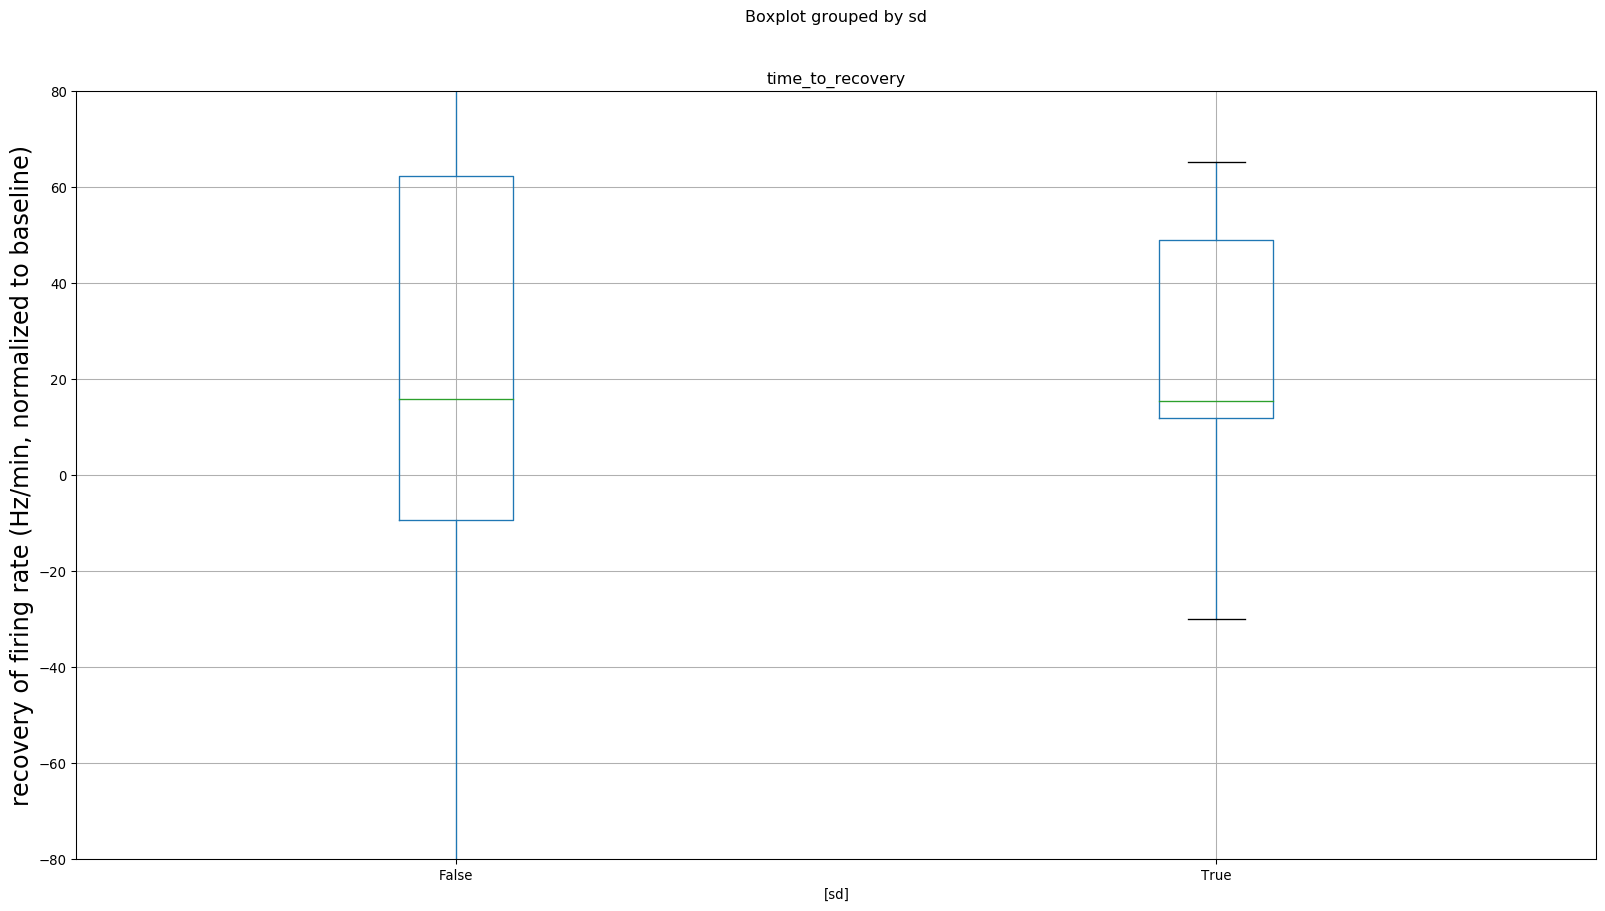

In [418]:
my_dpi = 96
fig, ax = plt.subplots(figsize=(1900/my_dpi, 1024/my_dpi), dpi=my_dpi)
linear.boxplot(column=['time_to_recovery'], 
               by=['sd'],  
               ax=ax,
              )
ax.set_ylim(-80,80)
ax.set_ylabel('recovery of firing rate (Hz/min, normalized to baseline)', fontsize=18)
plt.show()

/usr/lib/python3/dist-packages/matplotlib/cbook/__init__.py:1426: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


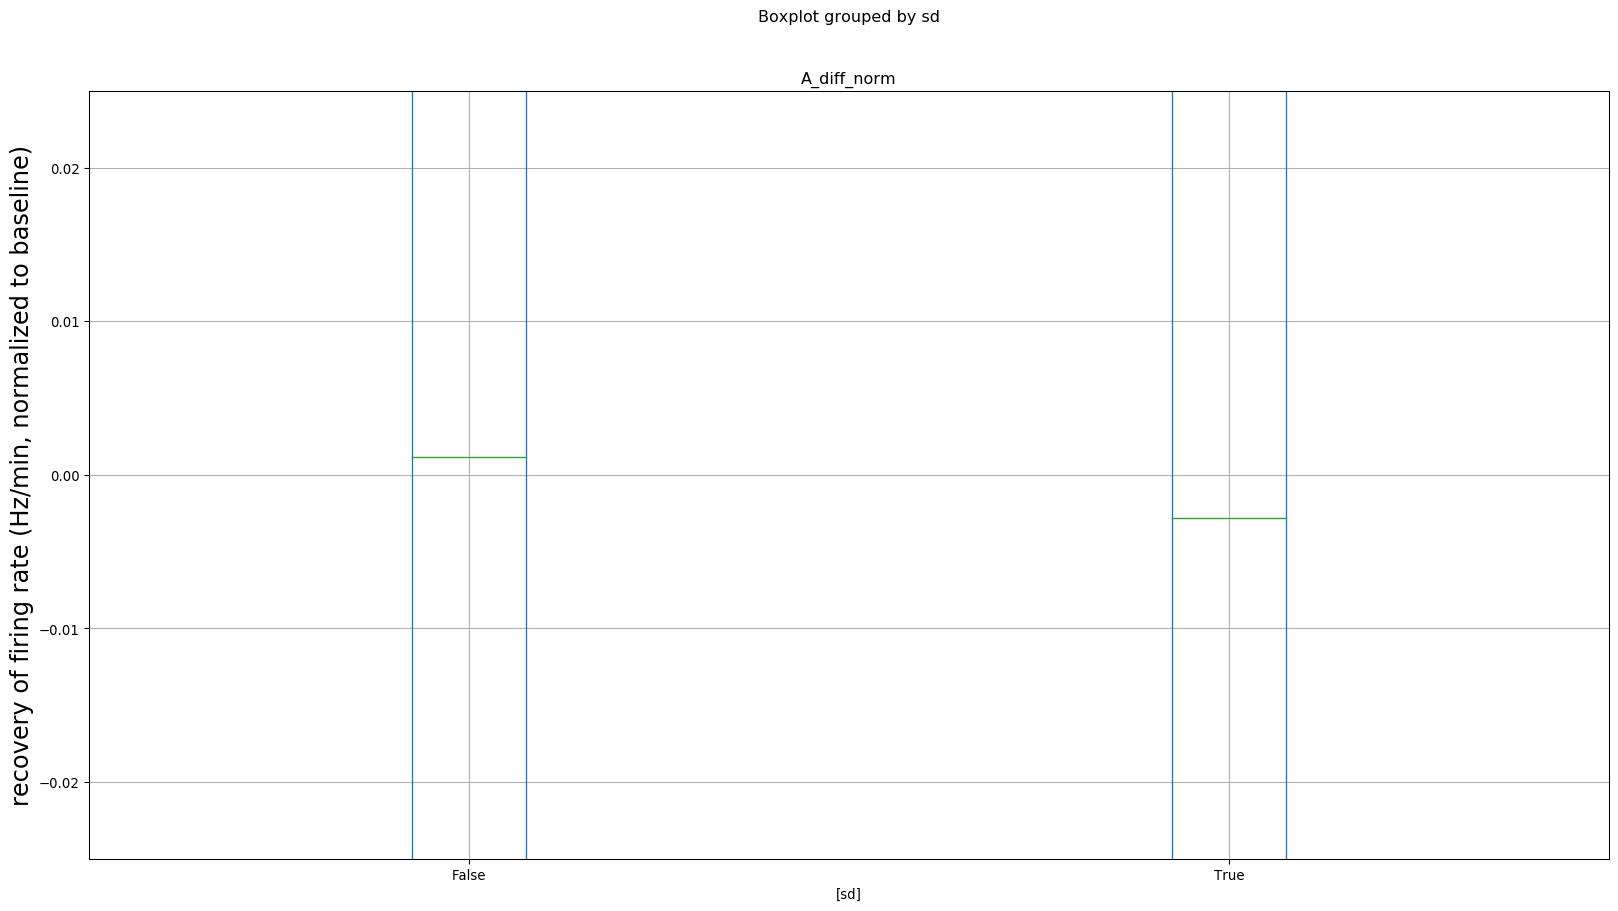

In [93]:
my_dpi = 96
fig, ax = plt.subplots(figsize=(1900/my_dpi, 1024/my_dpi), dpi=my_dpi)
linear.boxplot(column=['A_diff_norm'], 
               by=['sd'],  
               ax=ax,
              )
ax.set_ylim(-0.025,0.025)
ax.set_ylabel('recovery of firing rate (Hz/min, normalized to baseline)', fontsize=18)
plt.show()

In [94]:
linear.replace([np.inf, -np.inf], np.nan, inplace=True)
linear = linear[linear['A_norm'].notna()]
linear = linear[linear['A_diff_norm'].notna()]


g1_fit = linear[linear['sd']==True]
g2_fit = linear[linear['sd']==False]

In [95]:
g1_fit

,sd,region,baseline_mean,preictal_mean,1_mean,2_mean,3_mean,4_mean,5_mean,6_mean,...,21_mean,22_mean,23_mean,24_mean,25_mean,A_norm,B_norm,norm_mean_preictal,A_diff_norm,B_diff_norm
8,True,LAH,8.948333,7.300000,-0.038419,-0.020339,-0.022599,-0.027119,-0.072317,-0.030509,...,-0.171753,-0.284749,-0.272319,-0.350286,-0.311868,0.005594,0.047752,-1.648333,-0.003394,-0.028970
9,True,LAH,2.596667,0.883333,-0.044954,-0.041208,-0.048701,-0.086163,-0.153594,-0.535706,...,-0.198548,-0.243503,-0.505737,-2.869587,-1.311169,0.030442,0.126169,-1.713333,-0.017768,-0.073640
12,True,LAH,0.446667,0.266667,-1.658375,-1.865672,-1.451078,-0.621891,-2.694859,-1.451078,...,-0.414594,-1.658375,-1.036484,-9.742952,-7.255390,-0.007596,0.344350,-0.180000,0.042200,-1.913054
26,True,LMH,6.971667,6.683333,-0.588675,-0.505763,-0.596966,-0.887158,-0.970070,-0.671587,...,-1.326592,-1.807481,-1.641657,-2.686348,-2.097673,0.006190,0.175836,-0.288333,-0.021468,-0.609837
64,True,RAH,0.838333,0.783333,-27.110067,-17.711910,-13.012832,-34.700886,-35.423821,-31.809145,...,-43.014639,-22.772456,-42.653172,-45.183445,-55.304536,0.067381,1.002367,-0.055000,-1.225117,-18.224850
66,True,RAH,1.550000,2.283333,1.304985,1.671554,1.920821,1.788856,1.876833,1.495601,...,0.395894,0.278592,0.689150,0.938416,1.290323,-0.095046,1.429903,0.733333,-0.129608,1.949867
137,True,RA,0.146667,0.183333,77.479339,18.595041,92.975207,0.000000,18.595041,15.495868,...,0.000000,0.000000,0.000000,0.000000,NaN,-0.153815,1.882035,0.036667,-4.194953,51.328217
138,True,RA,1.878333,1.516667,-0.343475,-0.318941,-0.417077,-0.196272,-0.147204,-0.466145,...,-0.785087,-0.368009,-0.564281,-1.209174,NaN,0.000792,0.107238,-0.361667,-0.002191,-0.296510
139,True,RA,0.678333,0.433333,-0.802287,-0.702001,-0.802287,-0.501429,-0.401143,-0.501429,...,-0.300857,-0.000000,-0.300857,-0.859593,NaN,-0.011057,0.181818,-0.245000,0.045129,-0.742115
141,True,RA,0.705000,0.500000,-3.920890,-2.883008,-5.304734,-0.807242,-1.499164,-3.344289,...,-7.611140,-2.767687,-6.342617,-8.896138,NaN,-0.024485,0.654509,-0.205000,0.119439,-3.192725


In [96]:
stats.ttest_ind(g1_fit['A_norm'], g2_fit['A_norm'])

Ttest_indResult(statistic=-0.2826246765297824, pvalue=0.7779283150521648)

In [97]:
stats.ttest_ind(g1_fit['A_diff_norm'], g2_fit['A_diff_norm'])

Ttest_indResult(statistic=-1.2935824275309564, pvalue=0.1981760796692376)

In [98]:


a, b = np.polyfit(xaxis, only_columns.T[indices_names[3]], 1)   

a,b

NameError: name 'xaxis' is not defined

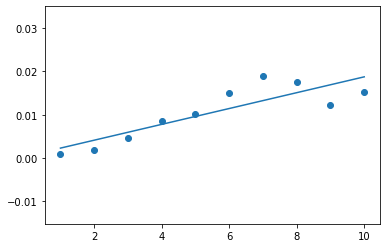

In [553]:
plt.scatter(xaxis, only_columns.T[indices_names[3]])
plt.plot(xaxis, a*xaxis+b)
plt.show()

In [441]:
reg

array([ 0.03474747, -0.05777778])

In [177]:
qry = "region=='LA'"
data_to_plot = df.query(qry)

In [402]:
df.T[]

,0,1,2,3,4,5,6,7,8,9,...,54,55,56,57,58,59,60,61,62,63
patID,092,092,092,092,092,092,092,092,092,092,...,092,092,092,092,092,092,092,092,092,092
seizureID,03,03,03,03,03,03,03,03,03,03,...,03,03,03,03,03,03,03,03,03,03
hemisphere,L,L,L,L,L,L,L,L,L,L,...,L,L,L,L,L,L,L,L,L,L
region,LA,LA,LA,LA,LA,LA,LA,LA,LAH,LAH,...,LTa,LTa,LTb,LTb,LTb,LTb,LTb,LTb,LTb,LTb
chname,LA1,LA2,LA3,LA4,LA5,LA6,LA7,LA8,LAH1,LAH2,...,LTa7,LTa8,LTb1,LTb2,LTb3,LTb4,LTb5,LTb6,LTb7,LTb8
seizureonset,2021-09-21_09-22-50,2021-09-21_09-22-50,2021-09-21_09-22-50,2021-09-21_09-22-50,2021-09-21_09-22-50,2021-09-21_09-22-50,2021-09-21_09-22-50,2021-09-21_09-22-50,2021-09-21_09-22-50,2021-09-21_09-22-50,...,2021-09-21_09-22-50,2021-09-21_09-22-50,2021-09-21_09-22-50,2021-09-21_09-22-50,2021-09-21_09-22-50,2021-09-21_09-22-50,2021-09-21_09-22-50,2021-09-21_09-22-50,2021-09-21_09-22-50,2021-09-21_09-22-50
sd,False,False,False,False,False,False,False,False,True,True,...,False,False,False,False,False,False,False,False,False,False
firingrate,"[1, 1, 0, 0, 5, 1, 1, 2, 1, 0, 1, 4, 3, 4, 3, ...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[2, 1, 5, 5, 5, 2, 5, 5, 1, 4, 5, 3, 5, 5, 1, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[7, 2, 8, 8, 17, 19, 12, 6, 1, 7, 12, 6, 12, 1...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[2, 2, 0, 7, 5, 2, 1, 2, 5, 0, 7, 6, 4, 2, 4, ...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[4, 13, 8, 15, 3, 6, 8, 11, 4, 5, 8, 11, 13, 1...","[0, 2, 0, 3, 0, 3, 2, 0, 0, 5, 1, 6, 3, 6, 1, ...",...,"[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ..."
baseline_mean,2.581667,NaN,6.206667,0.44,13.095,NaN,5.325,NaN,8.948333,2.596667,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
preictal_mean,2.183333,NaN,3.816667,0.266667,14.666667,NaN,4.683333,NaN,7.3,0.883333,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [212]:
xax

array([   0,    1,    2, ..., 3596, 3597, 3598])

In [215]:
plot = data_to_plot.plot(index=xax)

TypeError: no numeric data to plot

In [193]:
yax[0][0:30]

array([1, 1, 0, 0, 5, 1, 1, 2, 1, 0, 1, 4, 3, 4, 3, 2, 2, 0, 3, 4, 0, 0,
       1, 0, 0, 3, 2, 1, 1, 2])

In [199]:
len(yax[0])

3599

In [41]:
import seaborn as sns

In [136]:
xax

[0, 1, 2, 3, 4, 5, 6, 7]

/usr/lib/python3/dist-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  ndim = x[:, None].ndim
/usr/lib/python3/dist-packages/matplotlib/axes/_base.py:276: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
/usr/lib/python3/dist-packages/matplotlib/axes/_base.py:278: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]


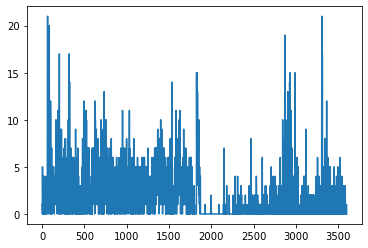

In [175]:
sns.lineplot(data_to_plot['firingrate'][0])

In [155]:
np.nanmean(data_to_plot['firingrate'], axis=0)

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

In [156]:
data_to_plot['firingrate']

0    [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, ...
1    [nan, nan, nan, nan, nan, nan, nan, nan, nan, ...
2    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
3    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
4    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
5    [nan, nan, nan, nan, nan, nan, nan, nan, nan, ...
6    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
7    [nan, nan, nan, nan, nan, nan, nan, nan, nan, ...
Name: firingrate, dtype: object

extracting spikes from CSC1.ncs
extracting spikes from CSC2.ncs
extracting spikes from CSC3.ncs
extracting spikes from CSC4.ncs
extracting spikes from CSC5.ncs
extracting spikes from CSC6.ncs
extracting spikes from CSC7.ncs
extracting spikes from CSC8.ncs
extracting spikes from CSC9.ncs
extracting spikes from CSC10.ncs
extracting spikes from CSC11.ncs
extracting spikes from CSC12.ncs
extracting spikes from CSC13.ncs
extracting spikes from CSC14.ncs
extracting spikes from CSC15.ncs
extracting spikes from CSC16.ncs
extracting spikes from CSC17.ncs
extracting spikes from CSC18.ncs
extracting spikes from CSC19.ncs
extracting spikes from CSC20.ncs
extracting spikes from CSC21.ncs
extracting spikes from CSC22.ncs
extracting spikes from CSC23.ncs
extracting spikes from CSC24.ncs
extracting spikes from CSC25.ncs
extracting spikes from CSC26.ncs
extracting spikes from CSC27.ncs
extracting spikes from CSC28.ncs
extracting spikes from CSC29.ncs
extracting spikes from CSC30.ncs
extracting spikes f

/tmp/ipykernel_508296/2734053310.py:41: RuntimeWarning: Mean of empty slice
  dict_pre[regname].append(np.nanmean(val))
/tmp/ipykernel_508296/2734053310.py:46: RuntimeWarning: Mean of empty slice
  dict_post[regname].append(np.nanmean(val))
/tmp/ipykernel_508296/2734053310.py:51: RuntimeWarning: Mean of empty slice
  dict_inter[regname].append(np.nanmean(val))
/tmp/ipykernel_508296/2734053310.py:55: RuntimeWarning: Mean of empty slice
  pre_norm[k] = np.divide(val, np.nanmean(dict_inter[k])).tolist()
/tmp/ipykernel_508296/2734053310.py:58: RuntimeWarning: Mean of empty slice
  post_norm[k] = np.divide(val, np.nanmean(dict_post[k])).tolist()
/usr/lib/python3/dist-packages/matplotlib/cbook/__init__.py:1426: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d

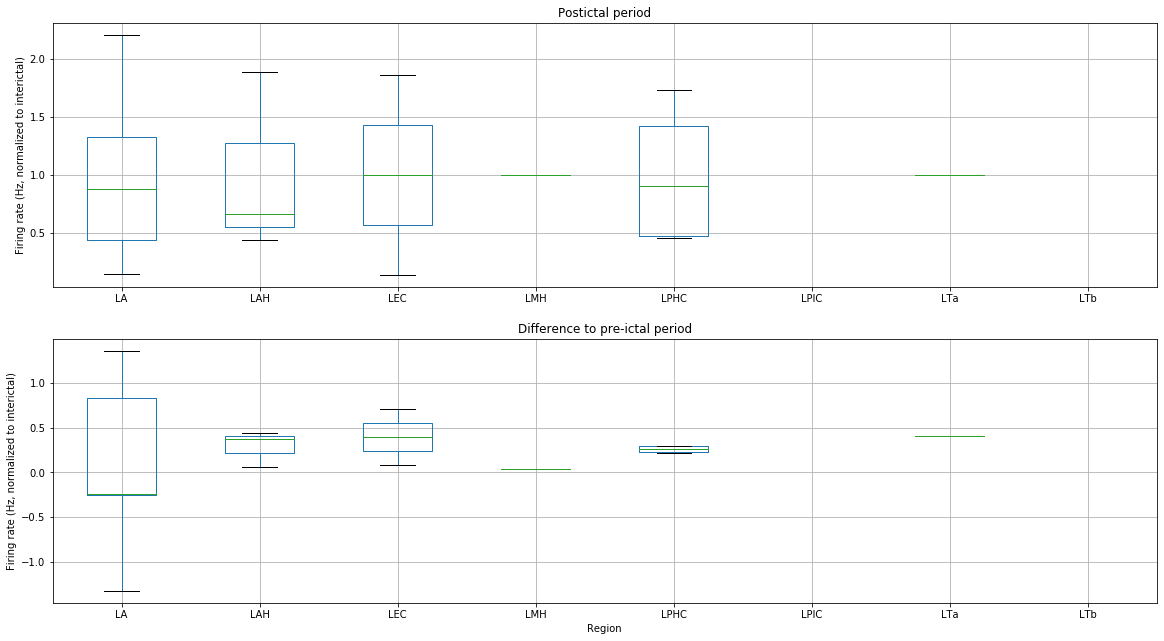

In [3]:
path = '/media/Seizures/60min_cut/092/2021-09-21_08-52-50'
date = '2021-09-21_09-22-50'
outfname = '1000msbinsize_all'
outdirname= 'firing_rate' 
binsize=1000
sec_before=-30*60
sec_after=30*60

regions = get_region_name(path, strip_ext=True)

res = do_complete_binned_firingrate(path, outfname, outdirname, date, binsize, sec_before, sec_after, save=False)

res = add_mean_and_std_per_region_to_firingrate_df(res, regions)

k_list = [key for key,val in res.items() if 'mean' in key]

df_preictal = cut_firingrates_data_df(res, binsize, offset=(29*60)-10, period=1*60)
df_posictal = cut_firingrates_data_df(res, binsize, offset=(31*60)+20, period=1*60)
df_interictal = cut_firingrates_data_df(res, binsize, offset=0, period=10*60)

dict_pre = dict()
dict_post = dict()
dict_inter = dict()

pre_norm = dict()
post_norm = dict()
diff_norm = dict()

for k in regions.keys():
    dict_pre[k] = []
    dict_post[k] = []
    dict_inter[k] = []
    pre_norm[k] = []
    post_norm[k] = []
    diff_norm[k] = []

#out_dict
for k, val in df_preictal.items():
    if '_' not in k :
        regname = k[:-1]
        dict_pre[regname].append(np.nanmean(val))

for k, val in df_posictal.items():
    if '_' not in k :
        regname = k[:-1]
        dict_post[regname].append(np.nanmean(val))

for k, val in df_interictal.items():
    if '_' not in k :
        regname = k[:-1]
        dict_inter[regname].append(np.nanmean(val))
        
        
for k, val in dict_pre.items():
    pre_norm[k] = np.divide(val, np.nanmean(dict_inter[k])).tolist()

for k, val in dict_post.items():
    post_norm[k] = np.divide(val, np.nanmean(dict_post[k])).tolist()
    
for k, val in post_norm.items():
    diff_norm[k] = np.subtract(val, pre_norm[k])
    
postictal_DF = pd.DataFrame(data=post_norm)
diff_DF = pd.DataFrame(data=diff_norm)

toplot_post = []
toplot_diff = []



my_dpi = 96
fig, axs= plt.subplots(2, figsize=(1900/my_dpi, 1024/my_dpi))

a = postictal_DF.boxplot(ax=axs[0] ) 
b = diff_DF.boxplot(ax=axs[1]) 


axs[0].set_title('Postictal period')
axs[1].set_title('Difference to pre-ictal period')
axs[0].set_ylabel('Firing rate (Hz, normalized to interictal)')
axs[1].set_ylabel('Firing rate (Hz, normalized to interictal)')
plt.xlabel('Region')

figpath = os.path.join(path, 'firing_rate')
figname = os.path.join(figpath, 'postictal_normalized_per_region')

if not os.path.exists(figpath):
    os.mkdir(figpath)
    
fig.savefig(figname)
plt.show()


In [6]:
path = '/media/Seizures/60min_cut/089/2021-04-19_03-43-56'
date = '2021-04-19_04-03-56'
outfname = '1000msbinsize_all'
outdirname= 'firing_rate' 
binsize=1000
sec_before=-30*60
sec_after=30*60

regions = get_region_name(path, strip_ext=True)

res = do_complete_binned_firingrate(path, outfname, outdirname, date, binsize, sec_before, sec_after, save=False)

res = add_mean_and_std_per_region_to_firingrate_df(res, regions)

k_list = [key for key,val in res.items() if 'mean' in key]

df_preictal = cut_firingrates_data_df(res, binsize, offset=(29*60)-10, period=1*60)
df_posictal = cut_firingrates_data_df(res, binsize, offset=(31*60)+30, period=1*60)
df_interictal = cut_firingrates_data_df(res, binsize, offset=0, period=10*60)

dict_pre = dict()
dict_post = dict()
dict_inter = dict()

pre_norm = dict()
post_norm = dict()
diff_norm = dict()

for k in regions.keys():
    dict_pre[k] = []
    dict_post[k] = []
    dict_inter[k] = []
    pre_norm[k] = []
    post_norm[k] = []
    diff_norm[k] = []

#out_dict
for k, val in df_preictal.items():
    if '_' not in k :
        regname = k[:-1]
        dict_pre[regname].append(np.nanmean(val))

for k, val in df_posictal.items():
    if '_' not in k :
        regname = k[:-1]
        dict_post[regname].append(np.nanmean(val))

for k, val in df_interictal.items():
    if '_' not in k :
        regname = k[:-1]
        dict_inter[regname].append(np.nanmean(val))
        
        
for k, val in dict_pre.items():
    pre_norm[k] = np.divide(val, np.nanmean(dict_inter[k])).tolist()

for k, val in dict_post.items():
    post_norm[k] = np.divide(val, np.nanmean(dict_post[k])).tolist()
    
for k, val in post_norm.items():
    diff_norm[k] = np.subtract(val, pre_norm[k])
    
postictal_DF = pd.DataFrame(data=post_norm)



path = '/media/Seizures/60min_cut/089/2021-04-19_03-43-56'
date = '2021-04-19_04-03-56'
outfname = '1000msbinsize_all'
outdirname= 'firing_rate' 
binsize=1000
sec_before=-30*60
sec_after=30*60

regions = get_region_name(path, strip_ext=True)

res = do_complete_binned_firingrate(path, outfname, outdirname, date, binsize, sec_before, sec_after, save=False)

res = add_mean_and_std_per_region_to_firingrate_df(res, regions)

k_list = [key for key,val in res.items() if 'mean' in key]

df_preictal = cut_firingrates_data_df(res, binsize, offset=(29*60)-10, period=1*60)
df_posictal = cut_firingrates_data_df(res, binsize, offset=(31*60)+30, period=1*60)
df_interictal = cut_firingrates_data_df(res, binsize, offset=0, period=10*60)

dict_pre = dict()
dict_post = dict()
dict_inter = dict()

pre_norm = dict()
post_norm = dict()
diff_norm = dict()

for k in regions.keys():
    diff_DF = pd.DataFrame(data=diff_norm)

toplot_post = []
toplot_diff = []



my_dpi = 96
fig, axs= plt.subplots(2, figsize=(1900/my_dpi, 1024/my_dpi))

a = postictal_DF.boxplot(ax=axs[0] ) 
b = diff_DF.boxplot(ax=axs[1]) 


axs[0].set_title('Postictal period')
axs[1].set_title('Difference to pre-ictal period')
axs[0].set_ylabel('Firing rate (Hz, normalized to interictal)')
axs[1].set_ylabel('Firing rate (Hz, normalized to interictal)')
plt.xlabel('Region')

figpath = os.path.join(path, 'firing_rate')
figname = os.path.join(figpath, 'postictal_normalized_per_region')

if not os.path.exists(figpath):
    os.mkdir(figpath)
    
fig.savefig(figname)
plt.show()

extracting spikes from CSC1.ncs
extracting spikes from CSC2.ncs
extracting spikes from CSC3.ncs
extracting spikes from CSC4.ncs
extracting spikes from CSC5.ncs
extracting spikes from CSC6.ncs
extracting spikes from CSC7.ncs
extracting spikes from CSC8.ncs
extracting spikes from CSC9.ncs
extracting spikes from CSC10.ncs
extracting spikes from CSC11.ncs
extracting spikes from CSC12.ncs
extracting spikes from CSC13.ncs
extracting spikes from CSC14.ncs
extracting spikes from CSC15.ncs
extracting spikes from CSC16.ncs
extracting spikes from CSC17.ncs
extracting spikes from CSC18.ncs
extracting spikes from CSC19.ncs
extracting spikes from CSC20.ncs
extracting spikes from CSC21.ncs
extracting spikes from CSC22.ncs
extracting spikes from CSC23.ncs
extracting spikes from CSC24.ncs
extracting spikes from CSC25.ncs
extracting spikes from CSC26.ncs
extracting spikes from CSC27.ncs
extracting spikes from CSC28.ncs
extracting spikes from CSC29.ncs
extracting spikes from CSC30.ncs
extracting spikes f

FileNotFoundError: [Errno 2] No such file or directory: '/media/Seizures/60min_cut/089/2021-04-19_03-43-56/times_CSC89.mat'

extracting spikes from CSC1.ncs
extracting spikes from CSC2.ncs
extracting spikes from CSC3.ncs
extracting spikes from CSC4.ncs
extracting spikes from CSC5.ncs
extracting spikes from CSC6.ncs
extracting spikes from CSC7.ncs
extracting spikes from CSC8.ncs
extracting spikes from CSC9.ncs
extracting spikes from CSC10.ncs
extracting spikes from CSC11.ncs
extracting spikes from CSC12.ncs
extracting spikes from CSC13.ncs
extracting spikes from CSC14.ncs
extracting spikes from CSC15.ncs
extracting spikes from CSC16.ncs
extracting spikes from CSC17.ncs
extracting spikes from CSC18.ncs
extracting spikes from CSC19.ncs
extracting spikes from CSC20.ncs
extracting spikes from CSC21.ncs
extracting spikes from CSC22.ncs
extracting spikes from CSC23.ncs
extracting spikes from CSC24.ncs
extracting spikes from CSC25.ncs
extracting spikes from CSC26.ncs
extracting spikes from CSC27.ncs
extracting spikes from CSC28.ncs
extracting spikes from CSC29.ncs
extracting spikes from CSC30.ncs
extracting spikes f

/usr/lib/python3/dist-packages/matplotlib/cbook/__init__.py:1426: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


ValueError: The truth value of a Series is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().

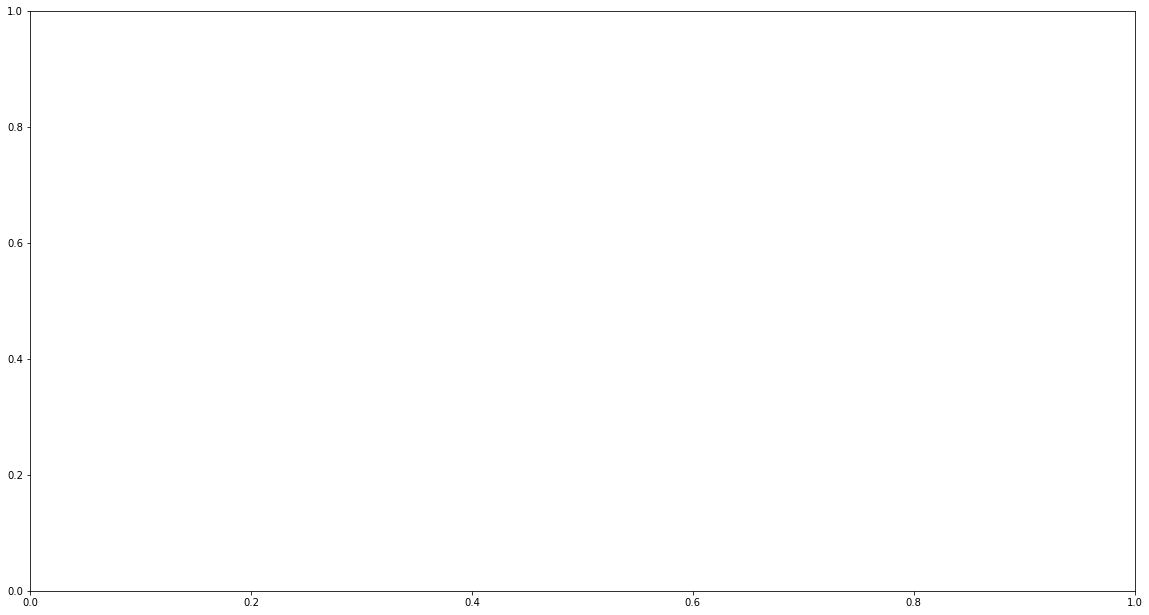

In [7]:
path = '/media/Seizures/60min_cut/092/2021-09-21_08-52-50'
date = '2021-09-21_09-22-50'
outfname = '1000msbinsize_all'
outdirname= 'firing_rate' 
binsize=1000
sec_before=-30*60
sec_after=30*60

regions = get_region_name(path, strip_ext=True)

res = do_complete_binned_firingrate(path, outfname, outdirname, date, binsize, sec_before, sec_after, save=False)

res = add_mean_and_std_per_region_to_firingrate_df(res, regions)


k_list = [key for key,val in res.items() if 'mean' in key]




df_interictal = cut_firingrates_data_df(res, binsize, offset=0, period=10*60,key_list=k_list)
df_baseline = cut_firingrates_data_df(res, binsize, offset=15*60, period=1*60,key_list=k_list)


my_dpi = 96
#fig = plt.figure(figsize=(1900/my_dpi, 1024/my_dpi))

min_to_try = 28

pval_df = dict()
pval_lst = pd.DataFrame()

for key in df_baseline.keys():
    fig = plt.figure(figsize=(1900/my_dpi, 1024/my_dpi))
    norm_bl = df_baseline[key]/np.nanmean(df_interictal[key])
    #to_plot = [norm_bl]
    to_plot = [np.nanmean(norm_bl)]
    
    #norm_posictal = df_posictal[key]/np.nanmean(df_interictal[key])
    for i in range(min_to_try):
        #print(i)
        #axs[i][0].boxplot(norm_bl)
        #axs[0][0].boxplot(norm_bl)
        #norm_bl = df_baseline[key]/np.nanmean(df_interictal[key])
        df_posictal = cut_firingrates_data_df(res, binsize, offset=((30+i+1)*60), period=1*60,key_list=k_list)
        norm_posictal = df_posictal[key]/np.nanmean(df_interictal[key])
        #axs[0][i].boxplot(norm_bl)
        #axs[i][0].boxplot(norm_bl)
        to_plot.append(norm_posictal)
        #pval_lst = pd.DataFrame()

        #for key, val in df_baseline.items():
        #norm_bl = df_baseline[key]/np.nanmean(df_interictal[key])
        #norm_posictal = df_posictal[key]/np.nanmean(df_interictal[key])
        #axs[0][0].boxplot(norm_bl)
        stats, pval = ranksums(norm_bl, norm_posictal)
        #print(key, pval) 
        #print(np.nanmean(norm_bl), np.nanmean(norm_posictal))

        pval_df[key] = pval

        #if pval <= 0.001 and np.mean(norm_bl) is not np.nan:
            #print(key, pval, i)
            #print(np.nanmean(norm_bl), np.nanmean(norm_posictal))
            #print(np.nanmean(norm_bl), np.nanmean(norm_posictal))
            #axs[i+1][i].boxplot(norm_posictal)

        #reg_counter +=1
    plt.boxplot(to_plot)
    plt.ylabel('Firing rate (Hz, normalized to interictal)')
    plt.xlabel('Minutes after seizure offset')
    xtick_numbers = [x+1 for x in range(min_to_try+1)]
    xtick_labels = ['baseline']
    for ix, xti in enumerate(xtick_numbers[:]):
        xtick_labels.append(str(xti))
    plt.xticks(xtick_numbers, xtick_labels)
    
    regname = key.split('_')[0]
    plt.title(f'Region: {regname}')
    
    figpath = os.path.join(path, 'firing_rate')
    
    if not os.path.exists(figpath):
        os.mkdir(figpath)
    
    figname = os.path.join(figpath, f"{regname}_regional_firing_rate_{min_to_try}_min_postictal")
    #print(figname)
    plt.savefig(figname)
    plt.show()

In [9]:
path = '/media/Seizures/60min_cut/092/2021-09-21_08-52-50'
date = '2021-09-21_09-22-50'
outfname = '1000msbinsize_all'
outdirname= 'firing_rate' 
binsize=1000
sec_before=-30*60
sec_after=30*60

regions = get_region_name(path, strip_ext=True)

res = do_complete_binned_firingrate(path, outfname, outdirname, date, binsize, sec_before, sec_after, save=False)

res = add_mean_and_std_per_region_to_firingrate_df(res, regions)


k_list = [key for key,val in res.items() if 'mean' in key]




df_interictal = cut_firingrates_data_df(res, binsize, offset=0, period=10*60,key_list=k_list)
df_baseline = cut_firingrates_data_df(res, binsize, offset=15*60, period=1*60,key_list=k_list)



#fig = plt.figure(figsize=(1900/my_dpi, 1024/my_dpi))

min_to_try = 28

means_dict = dict()
diffs_dict = dict()
pval_lst = pd.DataFrame()

for key in df_baseline.keys():
    #fig = plt.figure(figsize=(1900/my_dpi, 1024/my_dpi))
    norm_bl = df_baseline[key]/np.nanmean(df_interictal[key])
    baseline_mean = np.nanmean(norm_bl)
    #to_plot = [np.nanmean(norm_bl)]
    
    #if not baseline_mean:
    #    continue
    postictal_mean_list = []
    diff_mean_list = []
    #norm_posictal = df_posictal[key]/np.nanmean(df_interictal[key])
    for i in range(min_to_try):
        #print(i)
        #axs[i][0].boxplot(norm_bl)
        #axs[0][0].boxplot(norm_bl)
        #norm_bl = df_baseline[key]/np.nanmean(df_interictal[key])
        df_posictal = cut_firingrates_data_df(res, binsize, offset=((30+i+1)*60), period=1*60,key_list=k_list)
        norm_postictal = df_posictal[key]/np.nanmean(df_interictal[key])
        diff = np.subtract(norm_postictal, norm_bl)
        
        mean_postictal = np.nanmean(norm_postictal)
        mean_diff = np.nanmean(diff)
        
        postictal_mean_list.append(mean_postictal)
        diff_mean_list.append(mean_diff)
        #axs[0][i].boxplot(norm_bl)
        #axs[i][0].boxplot(norm_bl)
        #to_plot.append(norm_posictal)
        #pval_lst = pd.DataFrame()

        #for key, val in df_baseline.items():
        #norm_bl = df_baseline[key]/np.nanmean(df_interictal[key])
        #norm_posictal = df_posictal[key]/np.nanmean(df_interictal[key])
        #axs[0][0].boxplot(norm_bl)
        #stats, pval = ranksums(norm_bl, norm_posictal)
        #print(key, pval) 
        #print(np.nanmean(norm_bl), np.nanmean(norm_posictal))

        #pval_df[key] = pval

        #if pval <= 0.001 and np.mean(norm_bl) is not np.nan:
            #print(key, pval, i)
            #print(np.nanmean(norm_bl), np.nanmean(norm_posictal))
            #print(np.nanmean(norm_bl), np.nanmean(norm_posictal))
            #axs[i+1][i].boxplot(norm_posictal)
    means_dict[key] = postictal_mean_list
    diffs_dict[key] = diff_mean_list

extracting spikes from CSC1.ncs
extracting spikes from CSC2.ncs
extracting spikes from CSC3.ncs
extracting spikes from CSC4.ncs
extracting spikes from CSC5.ncs
extracting spikes from CSC6.ncs
extracting spikes from CSC7.ncs
extracting spikes from CSC8.ncs
extracting spikes from CSC9.ncs
extracting spikes from CSC10.ncs
extracting spikes from CSC11.ncs
extracting spikes from CSC12.ncs
extracting spikes from CSC13.ncs
extracting spikes from CSC14.ncs
extracting spikes from CSC15.ncs
extracting spikes from CSC16.ncs
extracting spikes from CSC17.ncs
extracting spikes from CSC18.ncs
extracting spikes from CSC19.ncs
extracting spikes from CSC20.ncs
extracting spikes from CSC21.ncs
extracting spikes from CSC22.ncs
extracting spikes from CSC23.ncs
extracting spikes from CSC24.ncs
extracting spikes from CSC25.ncs
extracting spikes from CSC26.ncs
extracting spikes from CSC27.ncs
extracting spikes from CSC28.ncs
extracting spikes from CSC29.ncs
extracting spikes from CSC30.ncs
extracting spikes f

/tmp/ipykernel_508296/155054028.py:55: RuntimeWarning: Mean of empty slice
  mean_diff = np.nanmean(diff)
/tmp/ipykernel_508296/155054028.py:55: RuntimeWarning: Mean of empty slice
  mean_diff = np.nanmean(diff)
/tmp/ipykernel_508296/155054028.py:55: RuntimeWarning: Mean of empty slice
  mean_diff = np.nanmean(diff)
/tmp/ipykernel_508296/155054028.py:55: RuntimeWarning: Mean of empty slice
  mean_diff = np.nanmean(diff)
/tmp/ipykernel_508296/155054028.py:55: RuntimeWarning: Mean of empty slice
  mean_diff = np.nanmean(diff)
/tmp/ipykernel_508296/155054028.py:55: RuntimeWarning: Mean of empty slice
  mean_diff = np.nanmean(diff)
/tmp/ipykernel_508296/155054028.py:55: RuntimeWarning: Mean of empty slice
  mean_diff = np.nanmean(diff)
/tmp/ipykernel_508296/155054028.py:55: RuntimeWarning: Mean of empty slice
  mean_diff = np.nanmean(diff)
/tmp/ipykernel_508296/155054028.py:55: RuntimeWarning: Mean of empty slice
  mean_diff = np.nanmean(diff)
/tmp/ipykernel_508296/155054028.py:55: Runtime

/tmp/ipykernel_508296/155054028.py:55: RuntimeWarning: Mean of empty slice
  mean_diff = np.nanmean(diff)
/tmp/ipykernel_508296/155054028.py:55: RuntimeWarning: Mean of empty slice
  mean_diff = np.nanmean(diff)
/tmp/ipykernel_508296/155054028.py:55: RuntimeWarning: Mean of empty slice
  mean_diff = np.nanmean(diff)
/tmp/ipykernel_508296/155054028.py:55: RuntimeWarning: Mean of empty slice
  mean_diff = np.nanmean(diff)
/tmp/ipykernel_508296/155054028.py:55: RuntimeWarning: Mean of empty slice
  mean_diff = np.nanmean(diff)
/tmp/ipykernel_508296/155054028.py:55: RuntimeWarning: Mean of empty slice
  mean_diff = np.nanmean(diff)
/tmp/ipykernel_508296/155054028.py:55: RuntimeWarning: Mean of empty slice
  mean_diff = np.nanmean(diff)
/tmp/ipykernel_508296/155054028.py:55: RuntimeWarning: Mean of empty slice
  mean_diff = np.nanmean(diff)
/tmp/ipykernel_508296/155054028.py:55: RuntimeWarning: Mean of empty slice
  mean_diff = np.nanmean(diff)
/tmp/ipykernel_508296/155054028.py:55: Runtime

/tmp/ipykernel_508296/155054028.py:55: RuntimeWarning: Mean of empty slice
  mean_diff = np.nanmean(diff)
/tmp/ipykernel_508296/155054028.py:55: RuntimeWarning: Mean of empty slice
  mean_diff = np.nanmean(diff)
/tmp/ipykernel_508296/155054028.py:55: RuntimeWarning: Mean of empty slice
  mean_diff = np.nanmean(diff)
/tmp/ipykernel_508296/155054028.py:55: RuntimeWarning: Mean of empty slice
  mean_diff = np.nanmean(diff)
/tmp/ipykernel_508296/155054028.py:55: RuntimeWarning: Mean of empty slice
  mean_diff = np.nanmean(diff)
/tmp/ipykernel_508296/155054028.py:55: RuntimeWarning: Mean of empty slice
  mean_diff = np.nanmean(diff)
/tmp/ipykernel_508296/155054028.py:55: RuntimeWarning: Mean of empty slice
  mean_diff = np.nanmean(diff)
/tmp/ipykernel_508296/155054028.py:55: RuntimeWarning: Mean of empty slice
  mean_diff = np.nanmean(diff)
/tmp/ipykernel_508296/155054028.py:55: RuntimeWarning: Mean of empty slice
  mean_diff = np.nanmean(diff)
/tmp/ipykernel_508296/155054028.py:36: Runtime

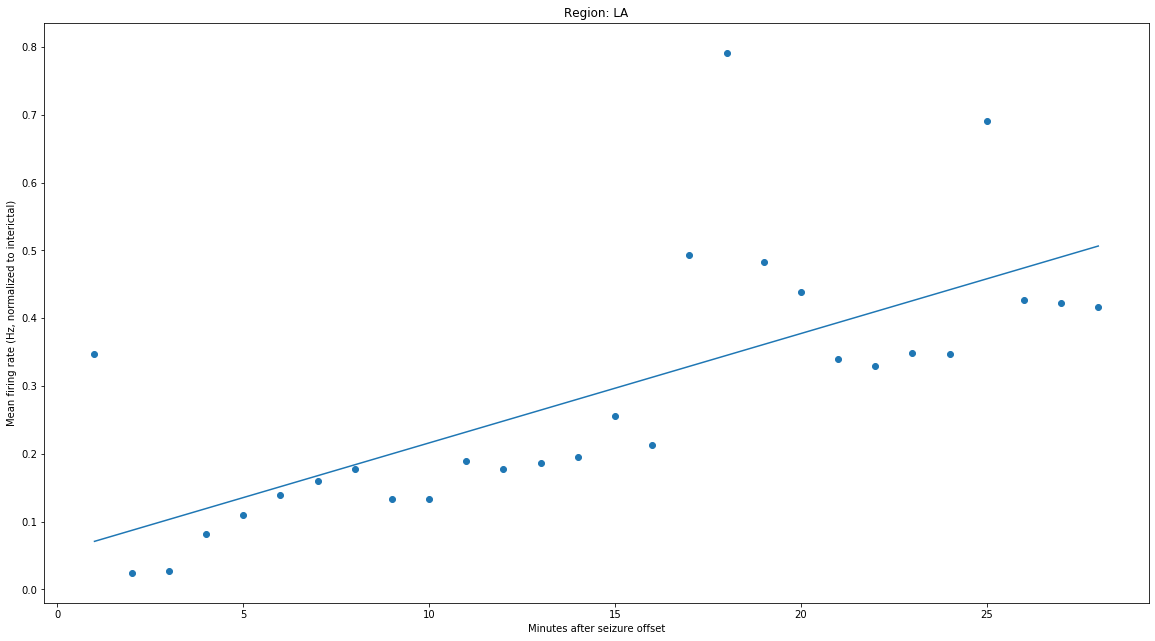

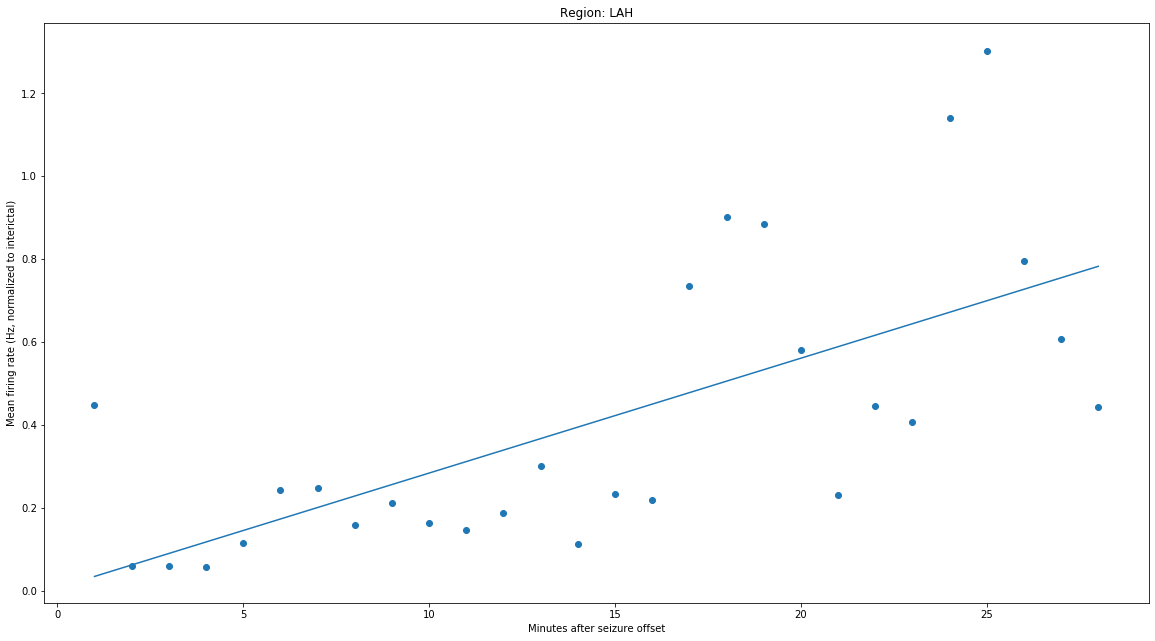

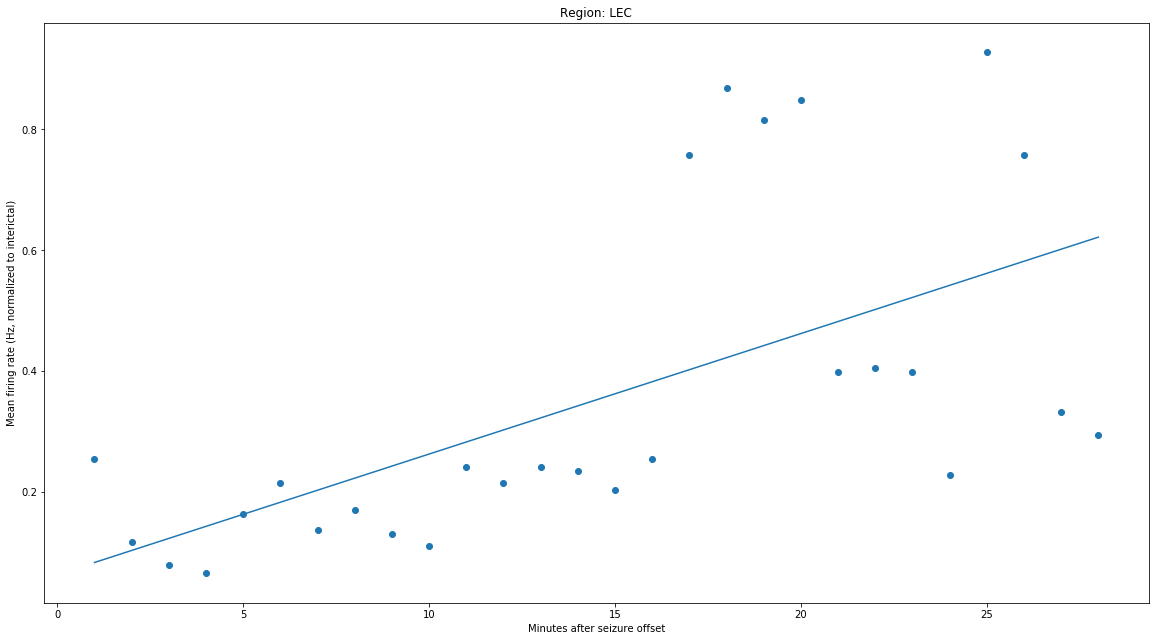

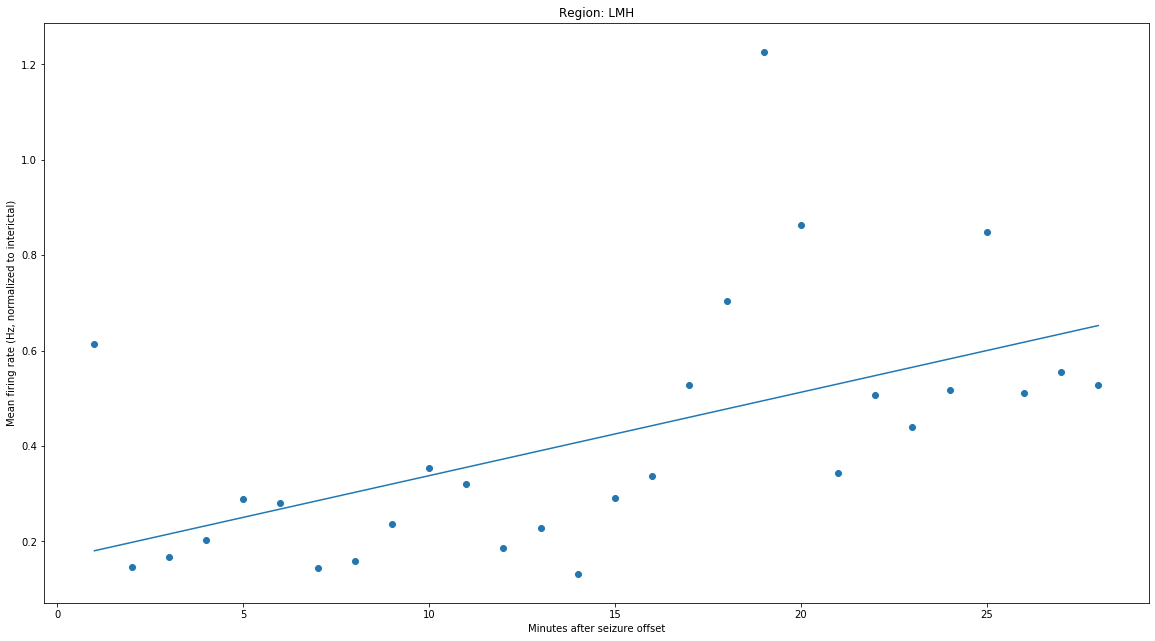

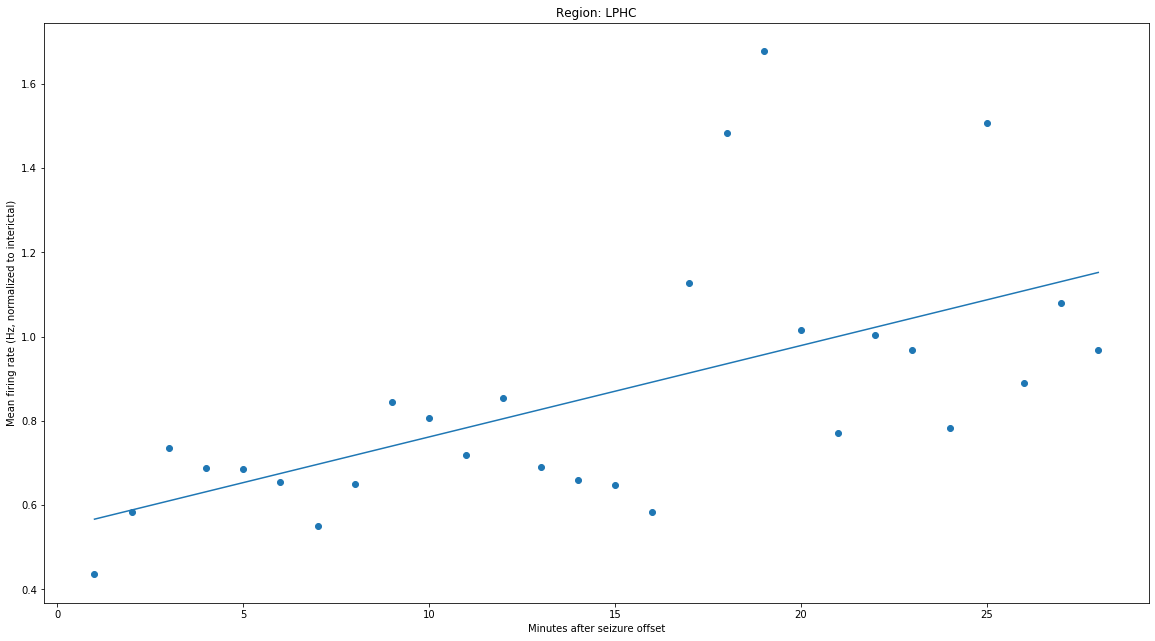

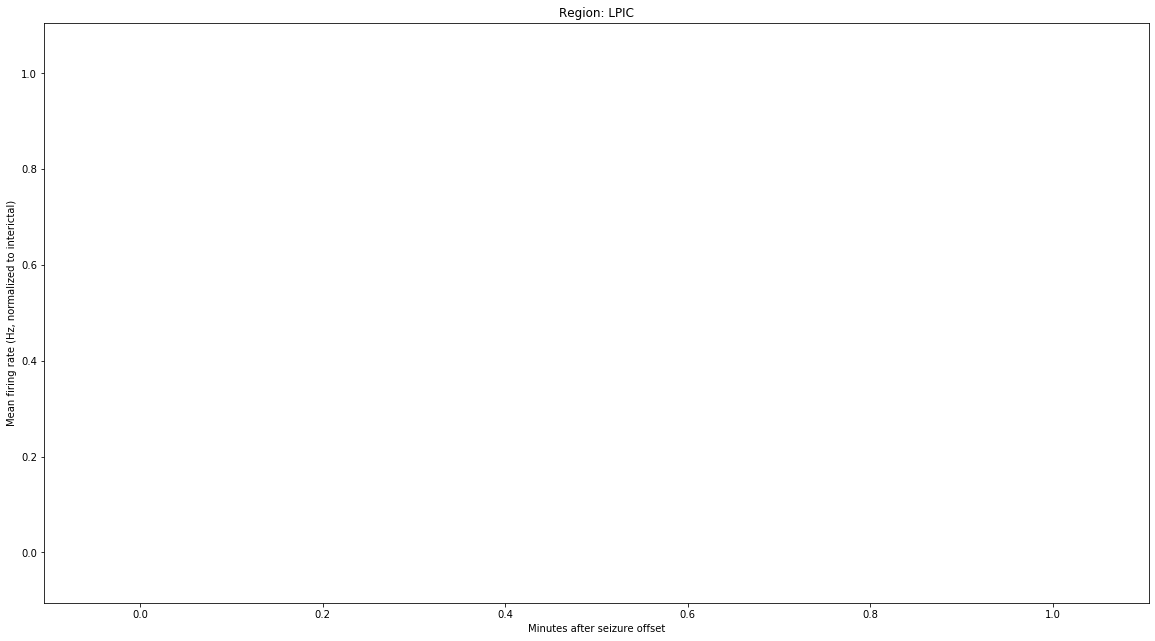

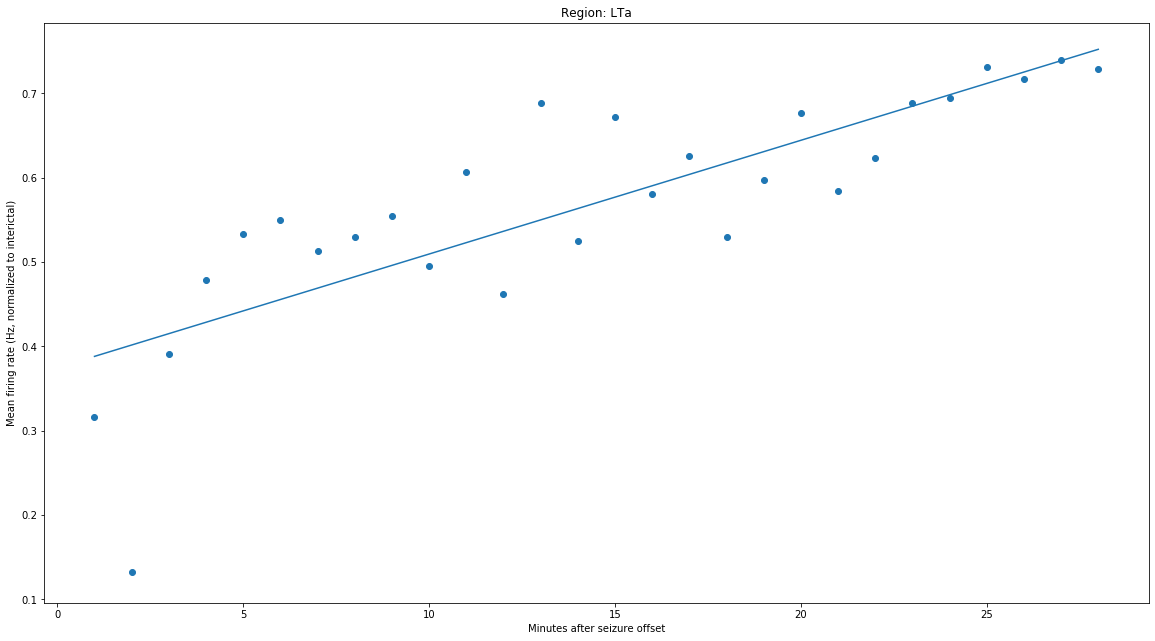

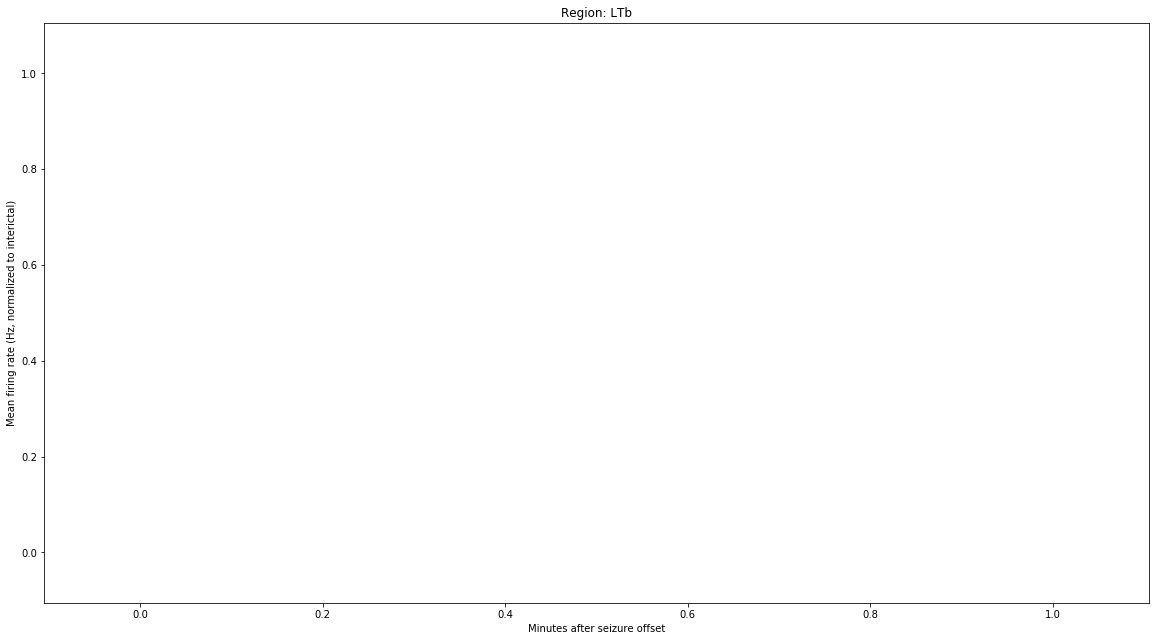

In [10]:
my_dpi = 96
min_to_try = 28

#fig, ax = plt.subplots(len(means_dict.keys()))
names = []
Bs = []
As = []
xaxis = np.arange(1,min_to_try+1)
for k, v in means_dict.items():
    #print(k)
    fig = plt.figure(figsize=(1900/my_dpi, 1024/my_dpi))
    if len(v):
        yaxis = np.asarray(v)
        
        a, b = np.polyfit(xaxis, yaxis, 1)
        names.append(k.split('_')[0])
        Bs.append(b)
        As.append(a)
        plt.scatter(xaxis, yaxis)
        plt.plot(xaxis, a*xaxis+b)
        
        plt.ylabel('Mean firing rate (Hz, normalized to interictal)')
        plt.xlabel('Minutes after seizure offset')
        regname = k.split('_')[0]
        plt.title(f'Region: {regname}')

In [ ]:
def extract_psd_per_bands(path):
    reref_path = find_dir(path, 'reref')
    fnames = match_cssfiles_to_chnames(path)
    chnames =get_chnames(path, strip=True)
    matfiles_data = [x.split('.')[0]+'_reref_data.mat' for x in fnames]
    matfiles_times = [x.split('.')[0]+'_reref_times.mat' for x in fnames]
    out_dict = dict(keys=chnames)
    
    
    for i, ch in enumerate(matfiles_data):
        print(f'extracting from {chname[i]}')
        
        file = readMatfile(os.path.join(rerefpath, ch))
        data = file.reref_data
        
        out_dic[chname[i]] = spectrogram(data, fs=1000, nperseg=1000, noverlap=0, scaling='density')
    
    return out_dic